In [71]:
import numpy as np
import matplotlib.pyplot as plt
import yt
from astropy.constants import G
import astropy.units as u
import seaborn as sns
from tqdm import tqdm
import os

In [2]:
def search_closest_upper(value, array):
    diff = array - value
    return np.where(diff >= 0)[0][0]

In [3]:
ray_tree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final_Thinh_structure.npy', allow_pickle=True).tolist()
apx_tree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1_no-shield/box_2_z_1_no-shield_run2/halotree_1088_final_Thinh_structure.npy', allow_pickle=True).tolist()

In [4]:
ray_pfs = np.loadtxt('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/pfs_allsnaps_1088.txt', dtype=str).tolist()
apx_pfs = np.loadtxt('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1_no-shield/box_2_z_1_no-shield_run2/pfs_allsnaps_1088.txt', dtype=str).tolist()

In [5]:
ray_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final.npy', allow_pickle=True).tolist()
#apx_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1_no-shield/box_2_z_1_no-shield_run2/halotree_1088_final.npy', allow_pickle=True).tolist()

In [4]:
time_list = np.array([ray_tree['0'][key]['time'] for key in ray_tree['0'].keys()])
idx_list = np.array([int(key) for key in ray_tree['0'].keys()])

In [5]:
ray_halo_wstars = {}
apx_halo_wstars = {}

In [7]:
idx = '170'

ray_halo_wstars_pos = np.empty(shape=(0,3))
ray_halo_wstars_rvir = np.array([])
ray_halo_wstars_branch = np.array([])
#ray_halo_wstars_dmmass = np.empty(shape=(0,1))

for key, vals in ray_tree.items():
    if idx in vals.keys() and vals[idx]['star_mass'] > 1:
        ray_halo_wstars[key] = vals[idx]
        ray_halo_wstars_pos = np.vstack((ray_halo_wstars_pos, vals[idx]['coor']))
        ray_halo_wstars_rvir = np.append(ray_halo_wstars_rvir, vals[idx]['Rvir'])
        ray_halo_wstars_branch = np.append(ray_halo_wstars_branch, key)
        
for key, vals in apx_tree.items():
    if idx in vals.keys() and vals[idx]['star_mass'] > 1:
        apx_halo_wstars[key] = vals[idx]

In [8]:
#Locate the overlapping halos. 
#For these halos, the stellar mass from the Thinh_structure file can be double counted. Therefore, we need to uniquely assign stars to each halo rather than loading the whole yt region.
overlap_pair = []
for i in range(len(ray_halo_wstars_branch)):
    for j in range(len(ray_halo_wstars_branch)):
        if (i == j) or sorted([ray_halo_wstars_branch[i],ray_halo_wstars_branch[j]]) in overlap_pair:
            continue
        else:
            if np.linalg.norm(ray_halo_wstars_pos[i] - ray_halo_wstars_pos[j]) < (ray_halo_wstars_rvir[i] + ray_halo_wstars_rvir[j]): #overlapping condition
                overlap_pair.append(sorted([ray_halo_wstars_branch[i],ray_halo_wstars_branch[j]]))

overlap_group = []
for pair in overlap_pair:
    if pair == overlap_pair[0]:
        group = pair
    else:
        if (pair[0] in group) or (pair[1] in group):
            group = list(set(group + pair))
        else:
            overlap_group.append(group)
            group = pair

In [9]:
#These are the groups of halos that need to be disentangled in terms of stellar mass
overlap_group

[['0_20', '0_21', '0', '0_16', '0_18', '0_19', '0_4', '0_2'],
 ['1', '1_14', '1_10'],
 ['3_1', '3', '3_7'],
 ['5', '5_1']]

In [76]:
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist())
ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])

In [79]:
group_test = np.array(overlap_group[0])
group_velcom = np.array([ray_rawtree[group_i][int(idx)]['Vel_Com'] for group_i in group_test])
#convert the unit of halo velocity from code_length/s to km/s
ds = yt.load(ray_pfs[int(idx)])
group_velcom = (group_velcom*ds.units.code_length/ds.units.s).to('km/s').v
group_starID = {}
allstars = []
for halo in group_test:
    halo_center = ray_tree[halo][idx]['coor']
    halo_radius = ray_tree[halo][idx]['Rvir']
    boolean = np.linalg.norm(ray_pos_all - halo_center, axis=1) < halo_radius
    group_starID[halo] = ray_ID_all[boolean].astype(int)
    allstars = list(set(allstars + list(ray_ID_all[boolean].astype(int))))
allstars = np.array(group_allstars)

yt : [INFO     ] 2024-12-10 10:23:52,751 Parameters: current_time              = 19.025726364245
yt : [INFO     ] 2024-12-10 10:23:52,752 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-12-10 10:23:52,754 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-12-10 10:23:52,762 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-12-10 10:23:52,765 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-12-10 10:23:52,768 Parameters: current_redshift          = 11.378797765779
yt : [INFO     ] 2024-12-10 10:23:52,770 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2024-12-10 10:23:52,773 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2024-12-10 10:23:52,774 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-12-10 10:23:52,774 Parameters: hubble_constant           = 0.679


In [32]:
group_starID

{'0_20': array([65363538, 65364102, 65364638, 65364670, 65364748]),
 '0_21': array([65731297, 65734353, 65734354, 65734355, 65734356, 65734357,
        65734358, 65734359, 65734360, 65734362, 65734363, 65734364,
        65734366]),
 '0': array([65363541, 65363542, 65364086, ..., 65665931, 65665937, 65724384]),
 '0_16': array([65363537, 65363546, 65363851, ..., 65665931, 65665937, 65724384]),
 '0_18': array([65363541, 65363542, 65364086, 65364088, 65364194, 65364698,
        65364664, 65364679, 65364681, 65614185, 65614414, 65617205,
        65659343, 65363652, 65363539, 65363540, 65363665, 65363673,
        65363674, 65363767, 65363773]),
 '0_19': array([65363541, 65363542, 65364086, 65364113, 65364693, 65364695,
        65364700, 65363652, 65363826, 65363539, 65363540, 65363665,
        65363673, 65363683, 65363767, 65363773, 65363831, 65364106]),
 '0_4': array([65364088, 65364194, 65364127, 65364129]),
 '0_2': array([65731297, 65734353, 65734354, 65734355, 65734356, 65734357,
       

In [33]:
allstars

array([65732608, 65658881, 65658882, ..., 65363965, 65724414, 65732607])

In [46]:
count_list = {}
for ID in allstars:
    count = 0
    branch_overlap = []
    for branch in group_starID.keys():
        if ID in group_starID[branch]:
            count += 1
            branch_overlap.append(branch)
    if count > 1:
        count_list[ID] = [count, branch_overlap]

In [85]:
ray_vel_all[ray_ID_all == 65732608]

array([[-65.81759841,  12.10400267, 120.21314368]])

In [90]:
ray_rawtree['0'][171]

{'NumParts': 10324,
 'Halo_Mass': 7628372984.201647,
 'Halo_Radius': 0.003219896406693052,
 'cden': 202.11934833096655,
 'r100': 0.0038463181360783145,
 'r150': 0.0036909953190874156,
 'r200': 0.003237456954225626,
 'r250': 0.0028894798550874417,
 'r300': 0.0026477752928777674,
 'r500': 0.0020518783497319,
 'r700': 0.001687430599046631,
 'Halo_Center': array([0.49444511, 0.50351903, 0.51216658]),
 'Vel_Com': array([-7.90055792e-19, -4.80827245e-20,  1.03378648e-19])}

In [86]:
count_list[65732608]

[2, ['0', '0_16']]

In [88]:
group_velcom[group_test == '0']

array([[-35.6028203 ,  -4.23333669,  10.90924301]])

In [89]:
group_velcom[group_test == '0_16']

array([[  8.91740217, -44.69326534,  60.8857723 ]])

In [65]:
group_test

['0_20', '0_21', '0_4', '0_16', '0', '0_18', '0_19', '0_2']

In [14]:
ray_pos_all.shape

(30056, 3)

In [17]:
ray_halo_wstars_pos

array([[0.49420246, 0.50316925, 0.51266823],
       [0.49296721, 0.50155015, 0.51324955],
       [0.47673882, 0.50389487, 0.5022506 ],
       [0.48908694, 0.50969391, 0.50063493],
       [0.50191681, 0.51200992, 0.53478709],
       [0.50191068, 0.51098171, 0.53401179],
       [0.50015472, 0.49932791, 0.512181  ],
       [0.48527808, 0.4967556 , 0.51121502],
       [0.50025661, 0.50790924, 0.53018027],
       [0.49264434, 0.51777617, 0.49249299],
       [0.48658425, 0.52111066, 0.52580045],
       [0.5022803 , 0.51522828, 0.53829083],
       [0.50312778, 0.51599952, 0.53952004]])

In [21]:
ray_halo_wstars.keys()

dict_keys(['0', '0_2', '1', '3', '4', '4_0', '5', '6', '8', '9', '18', '20', '69'])

In [22]:
ray_halo_wstars['0_2']

{'tree_loc': '0_2',
 'coor': array([0.49296721, 0.50155015, 0.51324955]),
 'Rvir': 0.0014047493591527603,
 'redshift': 10.886019680253,
 'time': 0.42308436376385633,
 'gas_mass': 170519124.77518892,
 'gas_mass_frac': 0.12780071866170767,
 'h2_mass': 5220394.575481022,
 'h2_fraction': 0.030614715987802243,
 'dm_mass': 1162249229.1687708,
 'pop2_mass': 1489589.9787338013,
 'pop3_mass': 5.17818883535532,
 'star_mass': 1489595.1569226366,
 'metal_mass': 14570.536272090665,
 'metallicity': 8.544810613648377e-05,
 'sfr': 0.0,
 'total_mass': 1334257949.1008823}

We need to assign each star to a unique halo. This can be done by tracking back the star's position when it first forms to see if it forms inside the same halo

In [8]:
ray_halo_idx = '0'
ray_halo_center = ray_tree[ray_halo_idx][idx]['coor']
ray_halo_rvir = ray_tree[ray_halo_idx][idx]['Rvir']

In [9]:
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist())

In [10]:
halo_star_pos = ray_pos_all[np.linalg.norm(ray_pos_all - ray_halo_center, axis=1) < ray_halo_rvir]
halo_star_age = ray_age_all[np.linalg.norm(ray_pos_all - ray_halo_center, axis=1) < ray_halo_rvir]
halo_star_ID = ray_ID_all[np.linalg.norm(ray_pos_all - ray_halo_center, axis=1) < ray_halo_rvir]

In [15]:
ftime_dict = {}
for j in range(len(halo_star_age)):
    ftime = time_list[-1] - halo_star_age[j]
    ftime_snapidx = idx_list[search_closest_upper(ftime, time_list)]
    try:
        ftime_dict[ftime_snapidx].append(int(halo_star_ID[j]))
    except:
        ftime_dict[ftime_snapidx] = []
        ftime_dict[ftime_snapidx].append(int(halo_star_ID[j]))

In [18]:
ftime_dict.keys()

dict_keys([80, 95, 117, 122, 124, 125, 154, 158, 159, 176, 190, 193, 194, 195, 201, 203, 130, 79, 156, 163, 198, 199, 114, 118, 200, 99, 109, 111, 112, 116, 119, 120, 121, 123, 127, 129, 131, 133, 134, 137, 138, 139, 141, 142, 143, 144, 160, 161, 175, 184, 202, 126, 150, 152, 162, 164, 169, 170, 174, 177, 178, 179, 183, 187, 191, 192, 204, 165, 180, 205, 206, 207, 208, 182, 209, 210, 211])

### Star Assignment Technique by Thinh

Starting from the earlier snapshot to the later snapshot. If a star particle is formed in a halo, assume that it will not escape that halo (there is a chance that during fly by, a DM halo can still some star particles, but since we are investigating star formation in halo, this can be neglected). If that halo is a sub branch, the star particle will belong to the main branch at the time step of merging. If a star particle is formed between the region of multiple halos, use energy definition to determine which halo it belongs to (choose the halo in which the star particle has the lowest total energy)

In [67]:
output = {}
for idx in ray_tree['0'].keys():
    output[str(idx)] = {}

In [6]:
def list_of_halos_wstars_idx(tree, idx):
    halo_wstars_pos = np.empty(shape=(0,3))
    halo_wstars_rvir = np.array([])
    halo_wstars_branch = np.array([])
    for key, vals in tree.items():
        if idx in vals.keys() and vals[idx]['star_mass'] > 1:
            halo_wstars_pos = np.vstack((halo_wstars_pos, vals[idx]['coor']))
            halo_wstars_rvir = np.append(halo_wstars_rvir, vals[idx]['Rvir'])
            halo_wstars_branch = np.append(halo_wstars_branch, key)   
    return halo_wstars_pos, halo_wstars_rvir, halo_wstars_branch

In [7]:
def univDen(ds):
    # Hubble constant
    H0 = ds.hubble_constant * 100 * u.km/u.s/u.Mpc
    H = H0**2 * (ds.omega_matter*(1 + ds.current_redshift)**3 + ds.omega_lambda)  # Technically H^2
    G = 6.67e-11 * u.m**3/u.s**2/u.kg
    # Density of the universe
    den = (3*H/(8*np.pi*G)).to("kg/m**3") / u.kg * u.m**3
    return den.value

def extract_char_radius(tree, branch, idx):
    oden_list = np.array([100, 150, 200, 250, 300, 500, 700])
    char_radius_list = np.array([])
    for oden in oden_list:
        key = 'r%s' % oden
        char_radius_list = np.append(char_radius_list, tree[branch][idx][key])
    return oden_list, char_radius_list

def find_total_E(star_pos, star_vel, ds, tree, branch, idx):
    #this function calculate the total orbital energy of a star around a halo
    #the unit of position is code_length and the unit of velocity is code_length/s
    star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'])
    star_r = (star_r_codelength*ds.units.code_length).to('m').v
    #
    halo_vel = (tree[branch][idx]['Vel_Com']*ds.units.code_length/ds.units.s).to('m/s').v
    star_relvel_mag = np.linalg.norm(star_vel - halo_vel)
    #Kinetic energy
    KE = 0.5*star_relvel_mag**2
    #Approximate M(r < star_r) by using the overdensity
    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)
    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v
    oden = oden_list[char_radius_list > star_r][-1]
    M = (4/3)*np.pi*oden*univDen(ds)*star_r**3
    PE = -G.value*M/star_r
    E = KE + PE
    return E

"""
def find_total_E_multiple(star_pos, star_vel, ds, tree, branch, idx):
    #this function calculate the total orbital energy of a star around a halo
    #the unit of position is km and the unit of velocity is km/s
    #star_pos is an array of stellar positions, star_vel is an array of stellar velocity
    star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'], axis=1)
    star_r = (star_r_codelength*ds.units.code_length).to('m').v
    #
    halo_vel = (tree[branch][idx]['Vel_Com']*ds.units.code_length/ds.units.s).to('m/s').v
    star_relvel_mag = np.linalg.norm(star_vel - halo_vel, axis=1)
    #Kinetic energy
    KE = 0.5*star_relvel_mag**2
    #Approximate M(r < star_r) by using the overdensity
    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)
    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v
    oden_boolean = char_radius_list > star_r[:,np.newaxis]
    oden = np.array([])
    for j in range(len(oden_boolean)):
        oden = np.append(oden, oden_list[np.where(oden_boolean[j] == True)[0][-1]])
    #
    M = (4/3)*np.pi*oden*univDen(ds)*star_r**3
    PE = -G.value*M/star_r
    E = KE + PE
    return E
"""

"\ndef find_total_E_multiple(star_pos, star_vel, ds, tree, branch, idx):\n    #this function calculate the total orbital energy of a star around a halo\n    #the unit of position is km and the unit of velocity is km/s\n    #star_pos is an array of stellar positions, star_vel is an array of stellar velocity\n    star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'], axis=1)\n    star_r = (star_r_codelength*ds.units.code_length).to('m').v\n    #\n    halo_vel = (tree[branch][idx]['Vel_Com']*ds.units.code_length/ds.units.s).to('m/s').v\n    star_relvel_mag = np.linalg.norm(star_vel - halo_vel, axis=1)\n    #Kinetic energy\n    KE = 0.5*star_relvel_mag**2\n    #Approximate M(r < star_r) by using the overdensity\n    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)\n    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v\n    oden_boolean = char_radius_list > star_r[:,np.newaxis]\n    oden = np.array([])\n    for j in range(len(o

In [8]:
ray_tree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final_Thinh_structure.npy', allow_pickle=True).tolist()
ray_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final.npy', allow_pickle=True).tolist()

In [80]:
print_mode = False

#for idx in tqdm(range(21, 212)):
for idx in tqdm(ray_tree['0'].keys()):
    idx = str(idx)
    #
    ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
    ray_pos_all = ray_metadata['pos']
    ray_age_all = ray_metadata['age']
    ray_mass_all = ray_metadata['mass']
    ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist()).astype(int)
    if os.path.exists('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx) == True:
        ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])
    else:
        ray_vel_all = np.empty(shape=(0,3))
    #
    if idx == list(ray_tree['0'].keys())[0]:
        ray_ID_all_prev = np.array([])
    #
    ray_ID_unassign = np.setdiff1d(ray_ID_all, ray_ID_all_prev)
    ray_pos_unassign = ray_pos_all[np.intersect1d(ray_ID_all, ray_ID_unassign, return_indices=True)[1]]
    ray_vel_unassign = ray_vel_all[np.intersect1d(ray_ID_all, ray_ID_unassign, return_indices=True)[1]]
    #Obtain the halos with stars
    halo_wstars_pos, halo_wstars_rvir, halo_wstars_branch = list_of_halos_wstars_idx(ray_tree, idx)
    #
    #The shape of halo_boolean is (X,Y), where X is the number of star particles and Y is the number of halos with stars
    halo_boolean = np.linalg.norm(ray_pos_unassign[:, np.newaxis, :] - halo_wstars_pos, axis=2) <= halo_wstars_rvir
    #The number of halos a star particle is in. For example, if this value = 2, the star particle is in the region of 2 halos
    overlap_boolean = np.sum(halo_boolean, axis=1) 
    #
    ray_ID_overlap = ray_ID_unassign[overlap_boolean > 1]
    halo_boolean_overlap = halo_boolean[overlap_boolean > 1]
    ray_ID_indp = ray_ID_unassign[overlap_boolean == 1]
    halo_boolean_indp = halo_boolean[overlap_boolean == 1]
    #
    #The list of stars in each halo's region
    starmap_ID = []
    for j in range(halo_boolean_indp.shape[1]):
        starmap_ID.append(ray_ID_indp[halo_boolean_indp[:,j]])
    #
    if len(ray_ID_overlap) > 0:
        ds = yt.load(ray_pfs[int(idx)])
        ray_pos_overlap = ray_pos_unassign[overlap_boolean > 1]
        ray_vel_overlap = ray_vel_unassign[overlap_boolean > 1]
        overlap_branch_total = []
        for k in range(len(ray_ID_overlap)):
            overlap_branch = halo_wstars_branch[halo_boolean_overlap[k]]
            E_list = np.array([])
            for branch in overlap_branch:
                overlap_branch_total.append(branch)
                E = find_total_E(ray_pos_overlap[k], ray_vel_overlap[k], ds, ray_rawtree, branch, int(idx))
                E_list = np.append(E_list, E)
            bound_branch = overlap_branch[np.argmin(E_list)]
            #print('Star ID', ray_ID_overlap[k], 'belong to Branch', bound_branch)
            starmap_ID[list(halo_wstars_branch).index(bound_branch)] = np.append(starmap_ID[list(halo_wstars_branch).index(bound_branch)], ray_ID_overlap[k])
        print('OVERLAP DETECTED AT BRANCHES', set(overlap_branch_total))
    len_starmap = [len(i) for i in starmap_ID]
    #
    for i in range(len(halo_wstars_branch)):
        if len(starmap_ID[i]) > 0: 
            for j in ray_tree[halo_wstars_branch[i]].keys(): #assuming when a star forms inside a halo, it will not leave that halo 
                if int(j) >= int(idx):
                    if halo_wstars_branch[i] not in output[j].keys():
                        output[j][halo_wstars_branch[i]] = starmap_ID[i]
                    else:
                        output[j][halo_wstars_branch[i]] = np.append(output[j][halo_wstars_branch[i]], starmap_ID[i])
            #for subbranch (or deeper sub-branch), the stars in that sub-branch will belong to the branch at lower level after the two halos merge
            nlevels = halo_wstars_branch[i].count('_')
            if nlevels > 1:
                print('DEEPER SUB-BRANCHES DETECTED')
            loop_branch = halo_wstars_branch[i]
            for level in range(nlevels): #add the stars in the sub-branch to higher branches
                deepest_lvl = loop_branch.split('_')[-1]
                mainbranch = loop_branch.split('_' + deepest_lvl)[0]
                merge_timestep = np.max(np.array(list(ray_tree[loop_branch].keys())).astype(int)) + 1
                last_timestep = np.max(np.array(list(ray_tree[mainbranch].keys())).astype(int))
                for j in range(merge_timestep, last_timestep + 1):
                    if mainbranch not in output[str(j)].keys():
                        output[str(j)][mainbranch] = starmap_ID[i]
                    else:
                        output[str(j)][mainbranch] = np.append(output[str(j)][mainbranch], starmap_ID[i])
                loop_branch = mainbranch
    #
    ray_ID_all_prev = ray_ID_all
    #
    if print_mode == True:
        print(idx, 'Number of total unassigned stars is:', len(ray_ID_unassign))
        print('Number of overlapped stars is', len(ray_ID_overlap), ', Number of independent stars is', len(ray_ID_indp))
        print('Halo with stars:', halo_wstars_branch)
        print('Number of assingned stars in each halo:', len_starmap, '\n')
        #print(starmap_ID,'\n')

 42%|████▏     | 87/208 [02:04<03:32,  1.76s/it]yt : [INFO     ] 2025-01-02 22:00:41,235 Parameters: current_time              = 14.485372364245
yt : [INFO     ] 2025-01-02 22:00:41,237 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:00:41,239 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:00:41,241 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:00:41,242 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:00:41,244 Parameters: current_redshift          = 13.847170857863
yt : [INFO     ] 2025-01-02 22:00:41,245 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:00:41,247 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:00:41,248 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:00:41,249 Parameters: hubble_constant           = 0.679
 42%|████▏     | 88/208 [02:12<06:48,  3.40s/it]

OVERLAP DETECTED AT BRANCHES {'1', '1_22'}


 44%|████▍     | 91/208 [02:17<04:38,  2.38s/it]yt : [INFO     ] 2025-01-02 22:00:50,034 Parameters: current_time              = 14.676545164245
yt : [INFO     ] 2025-01-02 22:00:50,037 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:00:50,039 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:00:50,041 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:00:50,043 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:00:50,045 Parameters: current_redshift          = 13.71792907663
yt : [INFO     ] 2025-01-02 22:00:50,047 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:00:50,049 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:00:50,051 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:00:50,053 Parameters: hubble_constant           = 0.679
 44%|████▍     | 92/208 [02:21<05:25,  2.81s/it]

OVERLAP DETECTED AT BRANCHES {'0_35', '0_34', '0'}


 45%|████▍     | 93/208 [02:26<06:51,  3.58s/it]yt : [INFO     ] 2025-01-02 22:01:02,766 Parameters: current_time              = 14.772131564245
yt : [INFO     ] 2025-01-02 22:01:02,768 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:01:02,769 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:01:02,771 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:01:02,773 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:01:02,774 Parameters: current_redshift          = 13.65435486334
yt : [INFO     ] 2025-01-02 22:01:02,776 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:01:02,777 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:01:02,779 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:01:02,780 Parameters: hubble_constant           = 0.679
 45%|████▌     | 94/208 [02:33<08:34,  4.51s/it]

OVERLAP DETECTED AT BRANCHES {'6', '6_6'}


yt : [INFO     ] 2025-01-02 22:01:07,601 Parameters: current_time              = 14.819924764245
yt : [INFO     ] 2025-01-02 22:01:07,603 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:01:07,604 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:01:07,606 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:01:07,608 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:01:07,609 Parameters: current_redshift          = 13.622824169978
yt : [INFO     ] 2025-01-02 22:01:07,610 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:01:07,612 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:01:07,613 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:01:07,615 Parameters: hubble_constant           = 0.679
 46%|████▌     | 95/208 [02:38<08:40,  4.60s/it]

OVERLAP DETECTED AT BRANCHES {'6', '6_6'}


yt : [INFO     ] 2025-01-02 22:01:15,423 Parameters: current_time              = 14.867717964245
yt : [INFO     ] 2025-01-02 22:01:15,425 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:01:15,427 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:01:15,429 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:01:15,430 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:01:15,432 Parameters: current_redshift          = 13.591462463737
yt : [INFO     ] 2025-01-02 22:01:15,433 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:01:15,435 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:01:15,436 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:01:15,438 Parameters: hubble_constant           = 0.679
 46%|████▌     | 96/208 [02:46<10:21,  5.55s/it]

OVERLAP DETECTED AT BRANCHES {'6', '0_35', '0', '6_6', '0_34'}


yt : [INFO     ] 2025-01-02 22:01:19,529 Parameters: current_time              = 14.915511164245
yt : [INFO     ] 2025-01-02 22:01:19,532 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:01:19,534 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:01:19,536 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:01:19,538 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:01:19,540 Parameters: current_redshift          = 13.560268299869
yt : [INFO     ] 2025-01-02 22:01:19,542 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:01:19,544 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:01:19,546 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:01:19,548 Parameters: hubble_constant           = 0.679
 47%|████▋     | 97/208 [02:50<09:29,  5.13s/it]

OVERLAP DETECTED AT BRANCHES {'6', '6_5'}


yt : [INFO     ] 2025-01-02 22:01:23,893 Parameters: current_time              = 14.963304364245
yt : [INFO     ] 2025-01-02 22:01:23,895 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:01:23,896 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:01:23,898 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:01:23,900 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:01:23,901 Parameters: current_redshift          = 13.529240250548
yt : [INFO     ] 2025-01-02 22:01:23,903 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:01:23,904 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:01:23,905 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:01:23,907 Parameters: hubble_constant           = 0.679
 47%|████▋     | 98/208 [02:54<08:58,  4.90s/it]

OVERLAP DETECTED AT BRANCHES {'6', '6_5'}


yt : [INFO     ] 2025-01-02 22:01:30,556 Parameters: current_time              = 15.011097564245
yt : [INFO     ] 2025-01-02 22:01:30,558 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:01:30,560 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:01:30,561 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:01:30,563 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:01:30,564 Parameters: current_redshift          = 13.498376904632
yt : [INFO     ] 2025-01-02 22:01:30,566 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:01:30,567 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:01:30,569 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:01:30,570 Parameters: hubble_constant           = 0.679
 48%|████▊     | 99/208 [03:01<09:52,  5.43s/it]

OVERLAP DETECTED AT BRANCHES {'6', '6_5'}


yt : [INFO     ] 2025-01-02 22:01:33,337 Parameters: current_time              = 15.058890764245
yt : [INFO     ] 2025-01-02 22:01:33,339 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:01:33,340 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:01:33,342 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:01:33,343 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:01:33,345 Parameters: current_redshift          = 13.467676867405
yt : [INFO     ] 2025-01-02 22:01:33,346 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:01:33,348 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:01:33,349 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:01:33,351 Parameters: hubble_constant           = 0.679
 48%|████▊     | 100/208 [03:05<08:41,  4.83s/it]

OVERLAP DETECTED AT BRANCHES {'6', '6_5'}


 51%|█████▏    | 107/208 [03:18<03:22,  2.00s/it]yt : [INFO     ] 2025-01-02 22:01:57,655 Parameters: current_time              = 15.441236364245
yt : [INFO     ] 2025-01-02 22:01:57,656 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:01:57,657 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:01:57,657 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:01:57,658 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:01:57,658 Parameters: current_redshift          = 13.227793550421
yt : [INFO     ] 2025-01-02 22:01:57,659 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:01:57,659 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:01:57,660 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:01:57,660 Parameters: hubble_constant           = 0.679
 52%|█████▏    | 108/208 [03:28<07:35,  4.56s/i

OVERLAP DETECTED AT BRANCHES {'0_30', '0'}


yt : [INFO     ] 2025-01-02 22:02:08,112 Parameters: current_time              = 15.489029564245
yt : [INFO     ] 2025-01-02 22:02:08,115 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:02:08,117 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:02:08,119 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:02:08,121 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:02:08,123 Parameters: current_redshift          = 13.19850312348
yt : [INFO     ] 2025-01-02 22:02:08,125 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:02:08,127 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:02:08,129 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:02:08,131 Parameters: hubble_constant           = 0.679
 52%|█████▏    | 109/208 [03:39<10:26,  6.32s/it]

OVERLAP DETECTED AT BRANCHES {'0_30', '0'}


 53%|█████▎    | 110/208 [03:41<08:26,  5.17s/it]yt : [INFO     ] 2025-01-02 22:02:12,590 Parameters: current_time              = 15.584615964245
yt : [INFO     ] 2025-01-02 22:02:12,591 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:02:12,593 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:02:12,595 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:02:12,596 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:02:12,598 Parameters: current_redshift          = 13.14037168221
yt : [INFO     ] 2025-01-02 22:02:12,599 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:02:12,601 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:02:12,602 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:02:12,603 Parameters: hubble_constant           = 0.679
 53%|█████▎    | 111/208 [03:43<06:48,  4.21s/it

OVERLAP DETECTED AT BRANCHES {'0_30', '0'}


yt : [INFO     ] 2025-01-02 22:02:21,479 Parameters: current_time              = 15.632409164245
yt : [INFO     ] 2025-01-02 22:02:21,482 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:02:21,483 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:02:21,485 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:02:21,486 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:02:21,488 Parameters: current_redshift          = 13.111528223491
yt : [INFO     ] 2025-01-02 22:02:21,489 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:02:21,491 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:02:21,492 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:02:21,493 Parameters: hubble_constant           = 0.679
 54%|█████▍    | 112/208 [03:52<08:58,  5.61s/it]

OVERLAP DETECTED AT BRANCHES {'1_18', '1'}


yt : [INFO     ] 2025-01-02 22:02:30,533 Parameters: current_time              = 15.680202364245
yt : [INFO     ] 2025-01-02 22:02:30,536 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:02:30,537 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:02:30,539 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:02:30,541 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:02:30,542 Parameters: current_redshift          = 13.082831332571
yt : [INFO     ] 2025-01-02 22:02:30,544 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:02:30,545 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:02:30,546 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:02:30,548 Parameters: hubble_constant           = 0.679
 54%|█████▍    | 113/208 [04:01<10:37,  6.71s/it]

OVERLAP DETECTED AT BRANCHES {'0_30', '0'}


yt : [INFO     ] 2025-01-02 22:02:34,131 Parameters: current_time              = 15.727995564245
yt : [INFO     ] 2025-01-02 22:02:34,133 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:02:34,135 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:02:34,137 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:02:34,139 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:02:34,141 Parameters: current_redshift          = 13.054279821133
yt : [INFO     ] 2025-01-02 22:02:34,143 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:02:34,145 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:02:34,147 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:02:34,149 Parameters: hubble_constant           = 0.679
 55%|█████▍    | 114/208 [04:05<09:16,  5.92s/it]

OVERLAP DETECTED AT BRANCHES {'0_30', '0'}


yt : [INFO     ] 2025-01-02 22:02:43,986 Parameters: current_time              = 15.775788764245
yt : [INFO     ] 2025-01-02 22:02:43,989 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:02:43,990 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:02:43,992 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:02:43,993 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:02:43,995 Parameters: current_redshift          = 13.025872514067
yt : [INFO     ] 2025-01-02 22:02:43,996 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:02:43,998 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:02:43,999 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:02:44,001 Parameters: hubble_constant           = 0.679
 55%|█████▌    | 115/208 [04:15<10:43,  6.92s/it]

OVERLAP DETECTED AT BRANCHES {'0_30', '0'}


yt : [INFO     ] 2025-01-02 22:02:44,759 Parameters: current_time              = 15.823581964245
yt : [INFO     ] 2025-01-02 22:02:44,761 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:02:44,764 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:02:44,766 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:02:44,768 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:02:44,770 Parameters: current_redshift          = 12.997608249284
yt : [INFO     ] 2025-01-02 22:02:44,772 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:02:44,774 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:02:44,776 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:02:44,777 Parameters: hubble_constant           = 0.679
 56%|█████▌    | 116/208 [04:15<07:49,  5.11s/it]

OVERLAP DETECTED AT BRANCHES {'4_10', '4', '0_30', '0'}


yt : [INFO     ] 2025-01-02 22:02:48,304 Parameters: current_time              = 15.871375164245
yt : [INFO     ] 2025-01-02 22:02:48,307 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:02:48,309 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:02:48,311 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:02:48,313 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:02:48,315 Parameters: current_redshift          = 12.969485877534
yt : [INFO     ] 2025-01-02 22:02:48,317 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:02:48,319 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:02:48,321 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:02:48,323 Parameters: hubble_constant           = 0.679
 56%|█████▋    | 117/208 [04:19<06:59,  4.61s/it]

OVERLAP DETECTED AT BRANCHES {'4_10', '4', '0_30', '0'}


yt : [INFO     ] 2025-01-02 22:02:55,674 Parameters: current_time              = 15.919168364245
yt : [INFO     ] 2025-01-02 22:02:55,677 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:02:55,679 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:02:55,681 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:02:55,683 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:02:55,685 Parameters: current_redshift          = 12.941504262223
yt : [INFO     ] 2025-01-02 22:02:55,687 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:02:55,689 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:02:55,691 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:02:55,693 Parameters: hubble_constant           = 0.679
 57%|█████▋    | 118/208 [04:26<08:07,  5.42s/it]

OVERLAP DETECTED AT BRANCHES {'1_18', '4_10', '4', '1'}


 57%|█████▋    | 119/208 [04:29<06:59,  4.71s/it]yt : [INFO     ] 2025-01-02 22:03:02,328 Parameters: current_time              = 16.014754764245
yt : [INFO     ] 2025-01-02 22:03:02,330 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:03:02,332 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:03:02,333 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:03:02,335 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:03:02,337 Parameters: current_redshift          = 12.885958816771
yt : [INFO     ] 2025-01-02 22:03:02,338 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:03:02,340 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:03:02,341 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:03:02,343 Parameters: hubble_constant           = 0.679
 58%|█████▊    | 120/208 [04:33<06:22,  4.35s/i

OVERLAP DETECTED AT BRANCHES {'0_29', '0'}


yt : [INFO     ] 2025-01-02 22:03:10,078 Parameters: current_time              = 16.062547964245
yt : [INFO     ] 2025-01-02 22:03:10,080 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:03:10,083 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:03:10,085 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:03:10,087 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:03:10,089 Parameters: current_redshift          = 12.858392775155
yt : [INFO     ] 2025-01-02 22:03:10,091 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:03:10,093 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:03:10,095 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:03:10,096 Parameters: hubble_constant           = 0.679
 58%|█████▊    | 121/208 [04:41<08:03,  5.56s/it]

OVERLAP DETECTED AT BRANCHES {'0_28', '0'}


 59%|█████▊    | 122/208 [04:45<07:06,  4.96s/it]yt : [INFO     ] 2025-01-02 22:03:18,131 Parameters: current_time              = 16.158134364245
yt : [INFO     ] 2025-01-02 22:03:18,134 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:03:18,136 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:03:18,138 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:03:18,140 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:03:18,142 Parameters: current_redshift          = 12.803668615465
yt : [INFO     ] 2025-01-02 22:03:18,144 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:03:18,146 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:03:18,148 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:03:18,150 Parameters: hubble_constant           = 0.679
 59%|█████▉    | 123/208 [04:49<06:35,  4.66s/i

OVERLAP DETECTED AT BRANCHES {'4_10', '4', '1429_0'}


yt : [INFO     ] 2025-01-02 22:03:21,221 Parameters: current_time              = 16.205927564245
yt : [INFO     ] 2025-01-02 22:03:21,223 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:03:21,225 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:03:21,227 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:03:21,229 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:03:21,231 Parameters: current_redshift          = 12.776508357231
yt : [INFO     ] 2025-01-02 22:03:21,233 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:03:21,235 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:03:21,237 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:03:21,239 Parameters: hubble_constant           = 0.679
 60%|█████▉    | 124/208 [04:52<05:56,  4.24s/it]

OVERLAP DETECTED AT BRANCHES {'4_10', '4', '1429_0'}


yt : [INFO     ] 2025-01-02 22:03:26,056 Parameters: current_time              = 16.253720764245
yt : [INFO     ] 2025-01-02 22:03:26,058 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:03:26,060 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:03:26,062 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:03:26,063 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:03:26,065 Parameters: current_redshift          = 12.749481239204
yt : [INFO     ] 2025-01-02 22:03:26,066 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:03:26,068 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:03:26,069 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:03:26,070 Parameters: hubble_constant           = 0.679
 60%|██████    | 125/208 [04:57<06:05,  4.41s/it]

OVERLAP DETECTED AT BRANCHES {'4_10', '4', '1429_0', '4_8'}


yt : [INFO     ] 2025-01-02 22:03:30,384 Parameters: current_time              = 16.301513964245
yt : [INFO     ] 2025-01-02 22:03:30,386 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:03:30,387 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:03:30,389 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:03:30,391 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:03:30,392 Parameters: current_redshift          = 12.722586219928
yt : [INFO     ] 2025-01-02 22:03:30,393 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:03:30,395 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:03:30,396 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:03:30,398 Parameters: hubble_constant           = 0.679
 61%|██████    | 126/208 [05:01<05:58,  4.37s/it]

OVERLAP DETECTED AT BRANCHES {'1429_0', '4', '0', '4_10', '4_8', '0_26'}


yt : [INFO     ] 2025-01-02 22:03:34,119 Parameters: current_time              = 16.349307164245
yt : [INFO     ] 2025-01-02 22:03:34,121 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:03:34,122 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:03:34,124 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:03:34,126 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:03:34,127 Parameters: current_redshift          = 12.695822269115
yt : [INFO     ] 2025-01-02 22:03:34,129 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:03:34,130 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:03:34,131 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:03:34,133 Parameters: hubble_constant           = 0.679
 61%|██████    | 127/208 [05:05<05:35,  4.15s/it]

OVERLAP DETECTED AT BRANCHES {'0_26', '0'}


yt : [INFO     ] 2025-01-02 22:03:45,984 Parameters: current_time              = 16.397100364245
yt : [INFO     ] 2025-01-02 22:03:45,987 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:03:45,989 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:03:45,991 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:03:45,993 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:03:45,995 Parameters: current_redshift          = 12.669188367492
yt : [INFO     ] 2025-01-02 22:03:45,997 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:03:45,999 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:03:46,001 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:03:46,003 Parameters: hubble_constant           = 0.679
 62%|██████▏   | 128/208 [05:17<08:36,  6.46s/it]

OVERLAP DETECTED AT BRANCHES {'0_26', '0'}


yt : [INFO     ] 2025-01-02 22:03:48,960 Parameters: current_time              = 16.444893564245
yt : [INFO     ] 2025-01-02 22:03:48,962 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:03:48,964 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:03:48,965 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:03:48,967 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:03:48,968 Parameters: current_redshift          = 12.642683506655
yt : [INFO     ] 2025-01-02 22:03:48,970 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:03:48,971 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:03:48,973 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:03:48,974 Parameters: hubble_constant           = 0.679
 62%|██████▏   | 129/208 [05:20<07:08,  5.43s/it]

OVERLAP DETECTED AT BRANCHES {'4', '4_8'}


yt : [INFO     ] 2025-01-02 22:03:51,838 Parameters: current_time              = 16.492686764245
yt : [INFO     ] 2025-01-02 22:03:51,841 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:03:51,843 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:03:51,845 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:03:51,847 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:03:51,849 Parameters: current_redshift          = 12.616306688919
yt : [INFO     ] 2025-01-02 22:03:51,851 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:03:51,853 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:03:51,855 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:03:51,857 Parameters: hubble_constant           = 0.679
 62%|██████▎   | 130/208 [05:23<06:08,  4.73s/it]

OVERLAP DETECTED AT BRANCHES {'4', '4_8'}


 64%|██████▍   | 133/208 [05:28<03:29,  2.80s/it]yt : [INFO     ] 2025-01-02 22:04:00,724 Parameters: current_time              = 16.683859564245
yt : [INFO     ] 2025-01-02 22:04:00,728 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:04:00,731 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:04:00,734 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:04:00,736 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:04:00,739 Parameters: current_redshift          = 12.512060262453
yt : [INFO     ] 2025-01-02 22:04:00,742 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:04:00,745 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:04:00,748 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:04:00,751 Parameters: hubble_constant           = 0.679
 64%|██████▍   | 134/208 [05:31<03:38,  2.95s/i

OVERLAP DETECTED AT BRANCHES {'4', '4_8'}


 66%|██████▌   | 137/208 [05:39<03:02,  2.57s/it]yt : [INFO     ] 2025-01-02 22:04:08,646 Parameters: current_time              = 16.875032364245
yt : [INFO     ] 2025-01-02 22:04:08,648 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:04:08,649 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:04:08,651 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:04:08,652 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:04:08,654 Parameters: current_redshift          = 12.40978540168
yt : [INFO     ] 2025-01-02 22:04:08,655 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:04:08,657 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:04:08,658 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:04:08,660 Parameters: hubble_constant           = 0.679
 66%|██████▋   | 138/208 [05:39<02:15,  1.93s/it

OVERLAP DETECTED AT BRANCHES {'4_7', '4'}


yt : [INFO     ] 2025-01-02 22:04:15,783 Parameters: current_time              = 16.922825564245
yt : [INFO     ] 2025-01-02 22:04:15,785 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:04:15,787 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:04:15,788 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:04:15,790 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:04:15,791 Parameters: current_redshift          = 12.384517775072
yt : [INFO     ] 2025-01-02 22:04:15,793 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:04:15,794 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:04:15,796 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:04:15,797 Parameters: hubble_constant           = 0.679
 67%|██████▋   | 139/208 [05:46<04:02,  3.51s/it]

OVERLAP DETECTED AT BRANCHES {'4_7_0', '4_7', '4'}


yt : [INFO     ] 2025-01-02 22:04:22,773 Parameters: current_time              = 16.970618764245
yt : [INFO     ] 2025-01-02 22:04:22,776 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:04:22,778 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:04:22,780 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:04:22,782 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:04:22,784 Parameters: current_redshift          = 12.359368773632
yt : [INFO     ] 2025-01-02 22:04:22,786 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:04:22,788 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:04:22,790 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:04:22,792 Parameters: hubble_constant           = 0.679
 67%|██████▋   | 140/208 [05:54<05:13,  4.61s/it]

OVERLAP DETECTED AT BRANCHES {'4_7', '4'}


yt : [INFO     ] 2025-01-02 22:04:27,616 Parameters: current_time              = 17.018411964245
yt : [INFO     ] 2025-01-02 22:04:27,619 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:04:27,621 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:04:27,623 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:04:27,626 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:04:27,628 Parameters: current_redshift          = 12.33433750855
yt : [INFO     ] 2025-01-02 22:04:27,629 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:04:27,631 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:04:27,633 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:04:27,635 Parameters: hubble_constant           = 0.679
 68%|██████▊   | 141/208 [05:58<05:08,  4.61s/it]

OVERLAP DETECTED AT BRANCHES {'3', '3_8'}


yt : [INFO     ] 2025-01-02 22:04:29,779 Parameters: current_time              = 17.066205164245
yt : [INFO     ] 2025-01-02 22:04:29,781 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:04:29,783 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:04:29,785 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:04:29,787 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:04:29,789 Parameters: current_redshift          = 12.309423100143
yt : [INFO     ] 2025-01-02 22:04:29,791 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:04:29,793 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:04:29,795 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:04:29,797 Parameters: hubble_constant           = 0.679
 68%|██████▊   | 142/208 [06:00<04:18,  3.91s/it]

OVERLAP DETECTED AT BRANCHES {'3', '3_8'}


 70%|██████▉   | 145/208 [06:07<02:39,  2.54s/it]yt : [INFO     ] 2025-01-02 22:04:40,478 Parameters: current_time              = 17.257377964245
yt : [INFO     ] 2025-01-02 22:04:40,480 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:04:40,481 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:04:40,483 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:04:40,485 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:04:40,486 Parameters: current_redshift          = 12.210916752618
yt : [INFO     ] 2025-01-02 22:04:40,488 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:04:40,489 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:04:40,490 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:04:40,492 Parameters: hubble_constant           = 0.679
 70%|███████   | 146/208 [06:11<03:09,  3.06s/i

OVERLAP DETECTED AT BRANCHES {'6', '6_4'}


yt : [INFO     ] 2025-01-02 22:04:43,379 Parameters: current_time              = 17.305171164245
yt : [INFO     ] 2025-01-02 22:04:43,381 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:04:43,383 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:04:43,386 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:04:43,388 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:04:43,390 Parameters: current_redshift          = 12.186573743727
yt : [INFO     ] 2025-01-02 22:04:43,392 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:04:43,393 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:04:43,395 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:04:43,397 Parameters: hubble_constant           = 0.679
 71%|███████   | 147/208 [06:14<03:06,  3.06s/it]

OVERLAP DETECTED AT BRANCHES {'6', '6_4'}


 72%|███████▏  | 149/208 [06:18<02:23,  2.44s/it]yt : [INFO     ] 2025-01-02 22:04:50,651 Parameters: current_time              = 17.448550764245
yt : [INFO     ] 2025-01-02 22:04:50,654 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:04:50,656 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:04:50,658 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:04:50,661 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:04:50,662 Parameters: current_redshift          = 12.114212032114
yt : [INFO     ] 2025-01-02 22:04:50,664 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:04:50,666 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:04:50,668 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:04:50,670 Parameters: hubble_constant           = 0.679
 72%|███████▏  | 150/208 [06:21<02:38,  2.74s/i

OVERLAP DETECTED AT BRANCHES {'44', '5'}


 73%|███████▎  | 151/208 [06:25<02:56,  3.09s/it]yt : [INFO     ] 2025-01-02 22:04:56,551 Parameters: current_time              = 17.544137164245
yt : [INFO     ] 2025-01-02 22:04:56,553 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:04:56,554 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:04:56,556 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:04:56,558 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:04:56,559 Parameters: current_redshift          = 12.06651889921
yt : [INFO     ] 2025-01-02 22:04:56,561 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:04:56,562 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:04:56,564 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:04:56,565 Parameters: hubble_constant           = 0.679
 73%|███████▎  | 152/208 [06:27<02:32,  2.73s/it

OVERLAP DETECTED AT BRANCHES {'1', '1_15'}


yt : [INFO     ] 2025-01-02 22:05:04,594 Parameters: current_time              = 17.591930364245
yt : [INFO     ] 2025-01-02 22:05:04,596 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:05:04,597 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:05:04,599 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:05:04,600 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:05:04,602 Parameters: current_redshift          = 12.042834351225
yt : [INFO     ] 2025-01-02 22:05:04,604 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:05:04,605 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:05:04,606 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:05:04,608 Parameters: hubble_constant           = 0.679
 74%|███████▎  | 153/208 [06:35<03:57,  4.32s/it]

OVERLAP DETECTED AT BRANCHES {'0_2_0', '1', '1_15', '0_2'}


yt : [INFO     ] 2025-01-02 22:05:07,851 Parameters: current_time              = 17.639723564245
yt : [INFO     ] 2025-01-02 22:05:07,853 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:05:07,855 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:05:07,857 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:05:07,859 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:05:07,861 Parameters: current_redshift          = 12.019256774436
yt : [INFO     ] 2025-01-02 22:05:07,863 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:05:07,864 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:05:07,866 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:05:07,868 Parameters: hubble_constant           = 0.679
 74%|███████▍  | 154/208 [06:39<03:39,  4.07s/it]

OVERLAP DETECTED AT BRANCHES {'44', '1_15', '5', '1'}


yt : [INFO     ] 2025-01-02 22:05:08,822 Parameters: current_time              = 17.687516764245
yt : [INFO     ] 2025-01-02 22:05:08,824 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:05:08,826 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:05:08,828 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:05:08,830 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:05:08,832 Parameters: current_redshift          = 11.995785397681
yt : [INFO     ] 2025-01-02 22:05:08,834 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:05:08,836 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:05:08,838 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:05:08,840 Parameters: hubble_constant           = 0.679
 75%|███████▍  | 155/208 [06:39<02:42,  3.07s/it]

OVERLAP DETECTED AT BRANCHES {'0_24', '0'}


yt : [INFO     ] 2025-01-02 22:05:12,641 Parameters: current_time              = 17.735309964245
yt : [INFO     ] 2025-01-02 22:05:12,643 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:05:12,645 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:05:12,647 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:05:12,648 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:05:12,650 Parameters: current_redshift          = 11.972419457422
yt : [INFO     ] 2025-01-02 22:05:12,651 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:05:12,653 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:05:12,654 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:05:12,656 Parameters: hubble_constant           = 0.679
 75%|███████▌  | 156/208 [06:43<02:50,  3.29s/it]

OVERLAP DETECTED AT BRANCHES {'0_24', '0'}


yt : [INFO     ] 2025-01-02 22:05:19,177 Parameters: current_time              = 17.783103164245
yt : [INFO     ] 2025-01-02 22:05:19,179 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:05:19,181 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:05:19,183 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:05:19,184 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:05:19,186 Parameters: current_redshift          = 11.949158197647
yt : [INFO     ] 2025-01-02 22:05:19,187 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:05:19,189 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:05:19,190 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:05:19,191 Parameters: hubble_constant           = 0.679
 75%|███████▌  | 157/208 [06:50<03:45,  4.41s/it]

OVERLAP DETECTED AT BRANCHES {'44', '0_24', '5', '0'}


yt : [INFO     ] 2025-01-02 22:05:27,135 Parameters: current_time              = 17.830896364245
yt : [INFO     ] 2025-01-02 22:05:27,137 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:05:27,140 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:05:27,142 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:05:27,144 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:05:27,146 Parameters: current_redshift          = 11.926000869779
yt : [INFO     ] 2025-01-02 22:05:27,148 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:05:27,150 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:05:27,152 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:05:27,154 Parameters: hubble_constant           = 0.679
 76%|███████▌  | 158/208 [06:58<04:28,  5.38s/it]

OVERLAP DETECTED AT BRANCHES {'0_24', '0'}


yt : [INFO     ] 2025-01-02 22:05:29,873 Parameters: current_time              = 17.878689564245
yt : [INFO     ] 2025-01-02 22:05:29,876 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:05:29,878 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:05:29,880 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:05:29,882 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:05:29,884 Parameters: current_redshift          = 11.902946732583
yt : [INFO     ] 2025-01-02 22:05:29,886 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:05:29,888 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:05:29,890 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:05:29,892 Parameters: hubble_constant           = 0.679
 76%|███████▋  | 159/208 [07:00<03:42,  4.54s/it]

OVERLAP DETECTED AT BRANCHES {'3', '3_8', '0_24', '0'}


yt : [INFO     ] 2025-01-02 22:05:33,114 Parameters: current_time              = 17.926482764245
yt : [INFO     ] 2025-01-02 22:05:33,117 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:05:33,119 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:05:33,121 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:05:33,123 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:05:33,125 Parameters: current_redshift          = 11.879995052069
yt : [INFO     ] 2025-01-02 22:05:33,127 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:05:33,129 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:05:33,131 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:05:33,133 Parameters: hubble_constant           = 0.679
 77%|███████▋  | 160/208 [07:04<03:20,  4.17s/it]

OVERLAP DETECTED AT BRANCHES {'0_24', '0_2', '0_4', '0', '0_21'}


yt : [INFO     ] 2025-01-02 22:05:36,579 Parameters: current_time              = 17.974275964245
yt : [INFO     ] 2025-01-02 22:05:36,582 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:05:36,584 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:05:36,586 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:05:36,588 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:05:36,590 Parameters: current_redshift          = 11.85714510141
yt : [INFO     ] 2025-01-02 22:05:36,592 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:05:36,594 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:05:36,596 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:05:36,598 Parameters: hubble_constant           = 0.679
 77%|███████▋  | 161/208 [07:07<03:09,  4.04s/it]

OVERLAP DETECTED AT BRANCHES {'3_8', '0_24', '3_7', '0_18', '3', '0', '0_4'}


yt : [INFO     ] 2025-01-02 22:05:41,163 Parameters: current_time              = 18.022069164245
yt : [INFO     ] 2025-01-02 22:05:41,165 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:05:41,167 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:05:41,169 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:05:41,170 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:05:41,172 Parameters: current_redshift          = 11.834396160849
yt : [INFO     ] 2025-01-02 22:05:41,173 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:05:41,174 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:05:41,176 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:05:41,177 Parameters: hubble_constant           = 0.679
 78%|███████▊  | 162/208 [07:12<03:08,  4.09s/it]

OVERLAP DETECTED AT BRANCHES {'3_8', '0_24', '3_7', '3', '0', '0_4'}


yt : [INFO     ] 2025-01-02 22:05:46,658 Parameters: current_time              = 18.069862364245
yt : [INFO     ] 2025-01-02 22:05:46,659 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:05:46,659 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:05:46,660 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:05:46,661 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:05:46,662 Parameters: current_redshift          = 11.811747517612
yt : [INFO     ] 2025-01-02 22:05:46,662 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:05:46,663 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:05:46,663 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:05:46,664 Parameters: hubble_constant           = 0.679
 78%|███████▊  | 163/208 [07:18<03:29,  4.65s/it]

OVERLAP DETECTED AT BRANCHES {'3_8', '1_15', '3_7', '3', '1', '1_10'}


yt : [INFO     ] 2025-01-02 22:05:49,021 Parameters: current_time              = 18.117655564245
yt : [INFO     ] 2025-01-02 22:05:49,024 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:05:49,026 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:05:49,028 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:05:49,030 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:05:49,032 Parameters: current_redshift          = 11.789198465821
yt : [INFO     ] 2025-01-02 22:05:49,034 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:05:49,036 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:05:49,038 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:05:49,040 Parameters: hubble_constant           = 0.679
 79%|███████▉  | 164/208 [07:20<02:54,  3.96s/it]

OVERLAP DETECTED AT BRANCHES {'1_15', '3_7', '3', '1', '3_1', '1_10'}


yt : [INFO     ] 2025-01-02 22:05:57,101 Parameters: current_time              = 18.165448764245
yt : [INFO     ] 2025-01-02 22:05:57,103 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:05:57,106 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:05:57,108 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:05:57,110 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:05:57,112 Parameters: current_redshift          = 11.766748306412
yt : [INFO     ] 2025-01-02 22:05:57,114 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:05:57,116 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:05:57,117 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:05:57,119 Parameters: hubble_constant           = 0.679
 79%|███████▉  | 165/208 [07:29<03:52,  5.41s/it]

OVERLAP DETECTED AT BRANCHES {'1_15', '3_7', '3', '1', '3_1', '1_10'}


yt : [INFO     ] 2025-01-02 22:06:00,819 Parameters: current_time              = 18.213241964245
yt : [INFO     ] 2025-01-02 22:06:00,820 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:06:00,821 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:06:00,822 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:06:00,823 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:06:00,824 Parameters: current_redshift          = 11.744396347051
yt : [INFO     ] 2025-01-02 22:06:00,825 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:06:00,825 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:06:00,826 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:06:00,827 Parameters: hubble_constant           = 0.679
 80%|███████▉  | 166/208 [07:32<03:18,  4.73s/it]

OVERLAP DETECTED AT BRANCHES {'1', '0_16', '1_10', '0'}


yt : [INFO     ] 2025-01-02 22:06:05,530 Parameters: current_time              = 18.261035164245
yt : [INFO     ] 2025-01-02 22:06:05,533 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:06:05,535 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:06:05,537 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:06:05,539 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:06:05,541 Parameters: current_redshift          = 11.722141902049
yt : [INFO     ] 2025-01-02 22:06:05,543 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:06:05,545 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:06:05,547 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:06:05,549 Parameters: hubble_constant           = 0.679
 80%|████████  | 167/208 [07:37<03:18,  4.83s/it]

OVERLAP DETECTED AT BRANCHES {'3_7', '5', '3', '1', '3_1', '0', '5_1', '0_16', '1_10'}


yt : [INFO     ] 2025-01-02 22:06:15,557 Parameters: current_time              = 18.308828364245
yt : [INFO     ] 2025-01-02 22:06:15,560 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:06:15,561 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:06:15,563 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:06:15,564 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:06:15,566 Parameters: current_redshift          = 11.699984292285
yt : [INFO     ] 2025-01-02 22:06:15,567 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:06:15,569 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:06:15,570 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:06:15,572 Parameters: hubble_constant           = 0.679
 81%|████████  | 168/208 [07:46<04:06,  6.16s/it]

OVERLAP DETECTED AT BRANCHES {'3', '1', '3_1', '1_10'}


yt : [INFO     ] 2025-01-02 22:06:20,911 Parameters: current_time              = 18.356621564245
yt : [INFO     ] 2025-01-02 22:06:20,914 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:06:20,916 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:06:20,919 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:06:20,921 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:06:20,923 Parameters: current_redshift          = 11.677922845122
yt : [INFO     ] 2025-01-02 22:06:20,925 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:06:20,927 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:06:20,928 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:06:20,930 Parameters: hubble_constant           = 0.679
 81%|████████▏ | 169/208 [07:52<03:54,  6.00s/it]

OVERLAP DETECTED AT BRANCHES {'3', '1', '3_1', '1_10'}


yt : [INFO     ] 2025-01-02 22:06:29,515 Parameters: current_time              = 18.404414764245
yt : [INFO     ] 2025-01-02 22:06:29,517 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:06:29,519 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:06:29,520 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:06:29,522 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:06:29,523 Parameters: current_redshift          = 11.655956894331
yt : [INFO     ] 2025-01-02 22:06:29,525 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:06:29,526 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:06:29,528 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:06:29,529 Parameters: hubble_constant           = 0.679
 82%|████████▏ | 170/208 [08:01<04:22,  6.92s/it]

OVERLAP DETECTED AT BRANCHES {'3_6', '3', '1', '3_1', '1_10'}


yt : [INFO     ] 2025-01-02 22:06:34,685 Parameters: current_time              = 18.452207964245
yt : [INFO     ] 2025-01-02 22:06:34,687 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:06:34,689 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:06:34,690 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:06:34,692 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:06:34,694 Parameters: current_redshift          = 11.634085780014
yt : [INFO     ] 2025-01-02 22:06:34,695 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:06:34,696 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:06:34,698 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:06:34,699 Parameters: hubble_constant           = 0.679
 82%|████████▏ | 171/208 [08:06<03:55,  6.37s/it]

OVERLAP DETECTED AT BRANCHES {'6', '5', '0_18', '3_6', '3', '1', '3_1', '5_1', '0', '6_2', '0_19', '0_16', '1_10'}


yt : [INFO     ] 2025-01-02 22:06:43,828 Parameters: current_time              = 18.500001164245
yt : [INFO     ] 2025-01-02 22:06:43,830 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:06:43,832 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:06:43,834 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:06:43,835 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:06:43,837 Parameters: current_redshift          = 11.612308848527
yt : [INFO     ] 2025-01-02 22:06:43,838 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:06:43,840 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:06:43,841 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:06:43,842 Parameters: hubble_constant           = 0.679
 83%|████████▎ | 172/208 [08:15<04:15,  7.09s/it]

OVERLAP DETECTED AT BRANCHES {'0_18', '3', '1', '3_1', '0', '8_1', '8_2', '0_16', '0_19', '8', '1_10'}


yt : [INFO     ] 2025-01-02 22:06:50,618 Parameters: current_time              = 18.547794364245
yt : [INFO     ] 2025-01-02 22:06:50,621 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:06:50,623 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:06:50,625 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:06:50,627 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:06:50,629 Parameters: current_redshift          = 11.590625452402
yt : [INFO     ] 2025-01-02 22:06:50,631 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:06:50,633 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:06:50,635 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:06:50,637 Parameters: hubble_constant           = 0.679
 83%|████████▎ | 173/208 [08:22<04:13,  7.25s/it]

OVERLAP DETECTED AT BRANCHES {'0_18', '3', '3_1', '0', '0_16', '0_19'}


yt : [INFO     ] 2025-01-02 22:06:54,220 Parameters: current_time              = 18.595587564245
yt : [INFO     ] 2025-01-02 22:06:54,222 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:06:54,224 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:06:54,226 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:06:54,228 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:06:54,230 Parameters: current_redshift          = 11.569034950277
yt : [INFO     ] 2025-01-02 22:06:54,232 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:06:54,234 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:06:54,236 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:06:54,238 Parameters: hubble_constant           = 0.679
 84%|████████▎ | 174/208 [08:25<03:17,  5.79s/it]

OVERLAP DETECTED AT BRANCHES {'0_18', '3', '3_1', '0', '0_16', '0_19'}


yt : [INFO     ] 2025-01-02 22:06:57,848 Parameters: current_time              = 18.643380764245
yt : [INFO     ] 2025-01-02 22:06:57,850 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:06:57,852 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:06:57,853 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:06:57,855 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:06:57,856 Parameters: current_redshift          = 11.547536706822
yt : [INFO     ] 2025-01-02 22:06:57,858 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:06:57,859 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:06:57,861 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:06:57,862 Parameters: hubble_constant           = 0.679
 84%|████████▍ | 175/208 [08:29<02:50,  5.18s/it]

OVERLAP DETECTED AT BRANCHES {'0_18', '3', '1', '3_1', '0', '8_1', '8_2', '0_16', '0_19', '8', '1_10'}


yt : [INFO     ] 2025-01-02 22:07:05,877 Parameters: current_time              = 18.691173964245
yt : [INFO     ] 2025-01-02 22:07:05,879 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:07:05,881 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:07:05,882 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:07:05,884 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:07:05,885 Parameters: current_redshift          = 11.526130092664
yt : [INFO     ] 2025-01-02 22:07:05,887 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:07:05,888 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:07:05,889 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:07:05,891 Parameters: hubble_constant           = 0.679
 85%|████████▍ | 176/208 [08:37<03:12,  6.02s/it]

OVERLAP DETECTED AT BRANCHES {'0_18', '3', '1', '3_1', '0', '0_19', '0_16', '1_10'}


yt : [INFO     ] 2025-01-02 22:07:17,303 Parameters: current_time              = 18.738967164245
yt : [INFO     ] 2025-01-02 22:07:17,306 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:07:17,308 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:07:17,310 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:07:17,312 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:07:17,314 Parameters: current_redshift          = 11.50481448432
yt : [INFO     ] 2025-01-02 22:07:17,316 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:07:17,318 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:07:17,320 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:07:17,322 Parameters: hubble_constant           = 0.679
 85%|████████▌ | 177/208 [08:48<03:56,  7.65s/it]

OVERLAP DETECTED AT BRANCHES {'0_18', '3', '1', '3_1', '0', '8_2', '0_16', '0_19', '8', '1_10'}


yt : [INFO     ] 2025-01-02 22:07:19,510 Parameters: current_time              = 18.786760364245
yt : [INFO     ] 2025-01-02 22:07:19,512 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:07:19,514 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:07:19,515 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:07:19,517 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:07:19,518 Parameters: current_redshift          = 11.483589264125
yt : [INFO     ] 2025-01-02 22:07:19,520 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:07:19,521 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:07:19,523 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:07:19,524 Parameters: hubble_constant           = 0.679
 86%|████████▌ | 178/208 [08:50<03:00,  6.01s/it]

OVERLAP DETECTED AT BRANCHES {'3', '1', '3_1', '1_8', '1_10'}


yt : [INFO     ] 2025-01-02 22:07:28,346 Parameters: current_time              = 18.834553564245
yt : [INFO     ] 2025-01-02 22:07:28,349 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:07:28,351 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:07:28,353 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:07:28,356 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:07:28,357 Parameters: current_redshift          = 11.462453820163
yt : [INFO     ] 2025-01-02 22:07:28,359 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:07:28,361 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:07:28,363 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:07:28,365 Parameters: hubble_constant           = 0.679
 86%|████████▌ | 179/208 [08:59<03:20,  6.93s/it]

OVERLAP DETECTED AT BRANCHES {'0_18', '3', '1', '3_1', '0', '1_8', '0_16', '1_10'}


yt : [INFO     ] 2025-01-02 22:07:34,468 Parameters: current_time              = 18.882346764245
yt : [INFO     ] 2025-01-02 22:07:34,470 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:07:34,473 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:07:34,475 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:07:34,477 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:07:34,479 Parameters: current_redshift          = 11.441407546199
yt : [INFO     ] 2025-01-02 22:07:34,481 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:07:34,483 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:07:34,485 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:07:34,486 Parameters: hubble_constant           = 0.679
 87%|████████▋ | 180/208 [09:06<03:10,  6.79s/it]

OVERLAP DETECTED AT BRANCHES {'0_18', '3', '1', '3_1', '0', '1_8', '0_16', '0_17', '1_10'}


yt : [INFO     ] 2025-01-02 22:07:39,239 Parameters: current_time              = 18.930139964245
yt : [INFO     ] 2025-01-02 22:07:39,241 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:07:39,243 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:07:39,246 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:07:39,248 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:07:39,250 Parameters: current_redshift          = 11.420449841614
yt : [INFO     ] 2025-01-02 22:07:39,252 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:07:39,254 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:07:39,256 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:07:39,258 Parameters: hubble_constant           = 0.679
 87%|████████▋ | 181/208 [09:11<02:51,  6.34s/it]

OVERLAP DETECTED AT BRANCHES {'3', '1', '3_1', '0', '1_8', '8_2', '8', '0_16', '3_2', '0_17', '1_10'}


yt : [INFO     ] 2025-01-02 22:07:45,891 Parameters: current_time              = 18.977933164245
yt : [INFO     ] 2025-01-02 22:07:45,893 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:07:45,896 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:07:45,898 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:07:45,900 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:07:45,902 Parameters: current_redshift          = 11.399580111337
yt : [INFO     ] 2025-01-02 22:07:45,904 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:07:45,906 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:07:45,908 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:07:45,909 Parameters: hubble_constant           = 0.679
 88%|████████▊ | 182/208 [09:18<02:47,  6.43s/it]

OVERLAP DETECTED AT BRANCHES {'3', '1', '3_1', '1_8', '8_2', '8', '1_10'}


yt : [INFO     ] 2025-01-02 22:07:52,066 Parameters: current_time              = 19.025726364245
yt : [INFO     ] 2025-01-02 22:07:52,067 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:07:52,067 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:07:52,068 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:07:52,069 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:07:52,070 Parameters: current_redshift          = 11.378797765779
yt : [INFO     ] 2025-01-02 22:07:52,070 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:07:52,071 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:07:52,071 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:07:52,072 Parameters: hubble_constant           = 0.679
 88%|████████▊ | 183/208 [09:23<02:33,  6.13s/it]

OVERLAP DETECTED AT BRANCHES {'3', '1', '3_1', '1_8', '8_2', '8', '1_10'}


yt : [INFO     ] 2025-01-02 22:07:53,370 Parameters: current_time              = 19.073519564245
yt : [INFO     ] 2025-01-02 22:07:53,371 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:07:53,372 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:07:53,373 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:07:53,374 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:07:53,374 Parameters: current_redshift          = 11.358102220772
yt : [INFO     ] 2025-01-02 22:07:53,375 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:07:53,375 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:07:53,376 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:07:53,377 Parameters: hubble_constant           = 0.679
 88%|████████▊ | 184/208 [09:24<01:49,  4.56s/it]

OVERLAP DETECTED AT BRANCHES {'3', '1', '3_1', '0', '1_8', '0_16', '1_10'}


yt : [INFO     ] 2025-01-02 22:07:55,376 Parameters: current_time              = 19.121312764245
yt : [INFO     ] 2025-01-02 22:07:55,378 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:07:55,380 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:07:55,382 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:07:55,384 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:07:55,386 Parameters: current_redshift          = 11.337492897503
yt : [INFO     ] 2025-01-02 22:07:55,388 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:07:55,390 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:07:55,392 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:07:55,394 Parameters: hubble_constant           = 0.679
 89%|████████▉ | 185/208 [09:26<01:26,  3.76s/it]

OVERLAP DETECTED AT BRANCHES {'8_2', '8'}


 90%|█████████ | 188/208 [09:36<01:01,  3.10s/it]yt : [INFO     ] 2025-01-02 22:08:08,339 Parameters: current_time              = 19.312485564245
yt : [INFO     ] 2025-01-02 22:08:08,341 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:08:08,343 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:08:08,344 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:08:08,346 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:08:08,347 Parameters: current_redshift          = 11.255906429548
yt : [INFO     ] 2025-01-02 22:08:08,349 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:08:08,350 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:08:08,352 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:08:08,353 Parameters: hubble_constant           = 0.679
 91%|█████████ | 189/208 [09:39<00:56,  2.97s/i

OVERLAP DETECTED AT BRANCHES {'0_13', '3', '3_1', '0'}


yt : [INFO     ] 2025-01-02 22:08:13,487 Parameters: current_time              = 19.360278764245
yt : [INFO     ] 2025-01-02 22:08:13,489 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:08:13,491 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:08:13,493 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:08:13,496 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:08:13,498 Parameters: current_redshift          = 11.235719715924
yt : [INFO     ] 2025-01-02 22:08:13,499 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:08:13,501 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:08:13,503 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:08:13,505 Parameters: hubble_constant           = 0.679
 91%|█████████▏| 190/208 [09:44<01:05,  3.64s/it]

OVERLAP DETECTED AT BRANCHES {'0_13', '3', '3_1', '0'}


yt : [INFO     ] 2025-01-02 22:08:19,369 Parameters: current_time              = 19.408071964245
yt : [INFO     ] 2025-01-02 22:08:19,371 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:08:19,372 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:08:19,374 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:08:19,376 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:08:19,377 Parameters: current_redshift          = 11.215615860209
yt : [INFO     ] 2025-01-02 22:08:19,378 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:08:19,380 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:08:19,381 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:08:19,383 Parameters: hubble_constant           = 0.679
 92%|█████████▏| 191/208 [09:51<01:17,  4.57s/it]

OVERLAP DETECTED AT BRANCHES {'0_13', '3', '3_1', '0'}


yt : [INFO     ] 2025-01-02 22:08:22,307 Parameters: current_time              = 19.455865164245
yt : [INFO     ] 2025-01-02 22:08:22,309 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:08:22,311 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:08:22,312 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:08:22,314 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:08:22,315 Parameters: current_redshift          = 11.195594319384
yt : [INFO     ] 2025-01-02 22:08:22,317 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:08:22,318 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:08:22,320 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:08:22,321 Parameters: hubble_constant           = 0.679
 92%|█████████▏| 192/208 [09:53<01:02,  3.91s/it]

OVERLAP DETECTED AT BRANCHES {'3', '0_13', '3_1', '0'}


yt : [INFO     ] 2025-01-02 22:08:28,591 Parameters: current_time              = 19.503658364245
yt : [INFO     ] 2025-01-02 22:08:28,594 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:08:28,596 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:08:28,598 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:08:28,600 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:08:28,602 Parameters: current_redshift          = 11.175654555311
yt : [INFO     ] 2025-01-02 22:08:28,604 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:08:28,606 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:08:28,608 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:08:28,610 Parameters: hubble_constant           = 0.679
 93%|█████████▎| 193/208 [09:59<01:07,  4.50s/it]

OVERLAP DETECTED AT BRANCHES {'9_1_0', '1', '9', '9_1_1_0', '1_8', '9_1'}
DEEPER SUB-BRANCHES DETECTED


yt : [INFO     ] 2025-01-02 22:08:33,913 Parameters: current_time              = 19.551451564245
yt : [INFO     ] 2025-01-02 22:08:33,916 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:08:33,918 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:08:33,920 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:08:33,922 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:08:33,924 Parameters: current_redshift          = 11.155796034681
yt : [INFO     ] 2025-01-02 22:08:33,926 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:08:33,928 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:08:33,930 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:08:33,932 Parameters: hubble_constant           = 0.679
 93%|█████████▎| 194/208 [10:04<01:05,  4.71s/it]

OVERLAP DETECTED AT BRANCHES {'9', '9_1_0', '9_1'}
DEEPER SUB-BRANCHES DETECTED


yt : [INFO     ] 2025-01-02 22:08:41,810 Parameters: current_time              = 19.599244764245
yt : [INFO     ] 2025-01-02 22:08:41,813 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:08:41,815 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:08:41,817 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:08:41,819 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:08:41,821 Parameters: current_redshift          = 11.136018228952
yt : [INFO     ] 2025-01-02 22:08:41,823 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:08:41,825 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:08:41,827 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:08:41,829 Parameters: hubble_constant           = 0.679
 94%|█████████▍| 195/208 [10:13<01:16,  5.85s/it]

OVERLAP DETECTED AT BRANCHES {'3', '1', '3_1', '0', '0_13', '1_8'}


yt : [INFO     ] 2025-01-02 22:08:43,962 Parameters: current_time              = 19.647037964245
yt : [INFO     ] 2025-01-02 22:08:43,964 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:08:43,966 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:08:43,968 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:08:43,970 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:08:43,972 Parameters: current_redshift          = 11.116320614298
yt : [INFO     ] 2025-01-02 22:08:43,974 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:08:43,976 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:08:43,978 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:08:43,980 Parameters: hubble_constant           = 0.679
 94%|█████████▍| 196/208 [10:15<00:55,  4.67s/it]

OVERLAP DETECTED AT BRANCHES {'0_13', '0'}


yt : [INFO     ] 2025-01-02 22:08:47,299 Parameters: current_time              = 19.694831164245
yt : [INFO     ] 2025-01-02 22:08:47,301 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:08:47,303 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:08:47,305 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:08:47,306 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:08:47,308 Parameters: current_redshift          = 11.096702671559
yt : [INFO     ] 2025-01-02 22:08:47,309 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:08:47,311 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:08:47,312 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:08:47,313 Parameters: hubble_constant           = 0.679
 95%|█████████▍| 197/208 [10:18<00:46,  4.22s/it]

OVERLAP DETECTED AT BRANCHES {'0_13', '0'}


yt : [INFO     ] 2025-01-02 22:08:55,442 Parameters: current_time              = 19.742624364245
yt : [INFO     ] 2025-01-02 22:08:55,445 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:08:55,447 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:08:55,449 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:08:55,451 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:08:55,453 Parameters: current_redshift          = 11.077163886182
yt : [INFO     ] 2025-01-02 22:08:55,455 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:08:55,457 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:08:55,458 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:08:55,460 Parameters: hubble_constant           = 0.679
 95%|█████████▌| 198/208 [10:27<00:55,  5.56s/it]

OVERLAP DETECTED AT BRANCHES {'3', '0_13', '3_1', '0'}


 96%|█████████▌| 199/208 [10:28<00:39,  4.40s/it]yt : [INFO     ] 2025-01-02 22:09:00,972 Parameters: current_time              = 19.838210764245
yt : [INFO     ] 2025-01-02 22:09:00,974 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:09:00,975 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:09:00,977 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:09:00,979 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:09:00,980 Parameters: current_redshift          = 11.038321752048
yt : [INFO     ] 2025-01-02 22:09:00,982 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:09:00,985 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:09:00,987 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:09:00,989 Parameters: hubble_constant           = 0.679
 96%|█████████▌| 200/208 [10:31<00:32,  4.01s/i

OVERLAP DETECTED AT BRANCHES {'9', '9_1_0', '9_1', '9_1_1'}


 97%|█████████▋| 201/208 [10:36<00:28,  4.02s/it]yt : [INFO     ] 2025-01-02 22:09:11,930 Parameters: current_time              = 19.933797164245
yt : [INFO     ] 2025-01-02 22:09:11,933 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:09:11,935 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:09:11,937 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:09:11,939 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:09:11,941 Parameters: current_redshift          = 10.999790185728
yt : [INFO     ] 2025-01-02 22:09:11,943 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:09:11,945 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:09:11,947 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:09:11,949 Parameters: hubble_constant           = 0.679
 97%|█████████▋| 202/208 [10:44<00:32,  5.48s/i

OVERLAP DETECTED AT BRANCHES {'9_1_0', '3', '9', '3_1', '9_1_1', '8_2', '8', '8_0', '9_1'}
DEEPER SUB-BRANCHES DETECTED


yt : [INFO     ] 2025-01-02 22:09:18,128 Parameters: current_time              = 19.981590364245
yt : [INFO     ] 2025-01-02 22:09:18,130 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:09:18,132 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:09:18,133 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:09:18,135 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:09:18,136 Parameters: current_redshift          = 10.980639626643
yt : [INFO     ] 2025-01-02 22:09:18,138 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:09:18,139 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:09:18,141 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:09:18,142 Parameters: hubble_constant           = 0.679
 98%|█████████▊| 203/208 [10:49<00:25,  5.15s/it]

OVERLAP DETECTED AT BRANCHES {'8_2', '8', '8_0'}


yt : [INFO     ] 2025-01-02 22:09:21,146 Parameters: current_time              = 20.029383564245
yt : [INFO     ] 2025-01-02 22:09:21,148 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:09:21,150 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:09:21,151 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:09:21,153 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:09:21,154 Parameters: current_redshift          = 10.961565231562
yt : [INFO     ] 2025-01-02 22:09:21,156 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:09:21,157 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:09:21,159 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:09:21,160 Parameters: hubble_constant           = 0.679
 98%|█████████▊| 204/208 [10:52<00:17,  4.46s/it]

OVERLAP DETECTED AT BRANCHES {'8_2', '8', '8_0'}


yt : [INFO     ] 2025-01-02 22:09:25,286 Parameters: current_time              = 20.077176764245
yt : [INFO     ] 2025-01-02 22:09:25,288 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:09:25,289 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:09:25,291 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:09:25,293 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:09:25,294 Parameters: current_redshift          = 10.942566516787
yt : [INFO     ] 2025-01-02 22:09:25,296 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:09:25,297 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:09:25,298 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:09:25,300 Parameters: hubble_constant           = 0.679
 99%|█████████▊| 205/208 [10:56<00:13,  4.46s/it]

OVERLAP DETECTED AT BRANCHES {'3', '3_1', '8_2', '8', '8_0'}


 99%|█████████▉| 206/208 [11:00<00:08,  4.30s/it]yt : [INFO     ] 2025-01-02 22:09:34,632 Parameters: current_time              = 20.172763164245
yt : [INFO     ] 2025-01-02 22:09:34,635 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 22:09:34,636 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 22:09:34,638 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 22:09:34,639 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 22:09:34,641 Parameters: current_redshift          = 10.904794214388
yt : [INFO     ] 2025-01-02 22:09:34,642 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 22:09:34,644 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 22:09:34,645 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 22:09:34,647 Parameters: hubble_constant           = 0.679
100%|█████████▉| 207/208 [11:05<00:04,  4.54s/i

OVERLAP DETECTED AT BRANCHES {'18_5', '18', '18_4'}


100%|██████████| 208/208 [11:07<00:00,  3.21s/it]


In [87]:
output_check = {}
for idx in output.keys():
    output_check[idx] = {}
    stars_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
    stars_pos_all = stars_metadata['pos']
    stars_mass_all = stars_metadata['mass']
    stars_age_all = stars_metadata['age']
    stars_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist()).astype(int)
    for branch in output[idx].keys():
        stars_ID = output[idx][branch]
        stars_pos = stars_pos_all[np.intersect1d(stars_ID_all, stars_ID, return_indices=True)[1]]
        stars_mass = stars_mass_all[np.intersect1d(stars_ID_all, stars_ID, return_indices=True)[1]]
        stars_age = stars_age_all[np.intersect1d(stars_ID_all, stars_ID, return_indices=True)[1]]
        stars_ID = stars_ID_all[np.intersect1d(stars_ID_all, stars_ID, return_indices=True)[1]]
        #
        halo_center = ray_rawtree[branch][int(idx)]['Halo_Center']
        halo_radius = ray_rawtree[branch][int(idx)]['Halo_Radius']
        #
        check_bool = np.linalg.norm(stars_pos - halo_center, axis=1) < halo_radius
        stars_ID_check = stars_ID[check_bool]
        stars_pos_check = stars_pos[check_bool]
        stars_mass_check = stars_mass[check_bool]
        stars_age_check = stars_age[check_bool]
        output_check[idx][branch] = {}
        output_check[idx][branch]['ID'] = stars_ID_check
        output_check[idx][branch]['total_mass'] = np.sum(stars_mass_check)
        output_check[idx][branch]['sfr'] = np.sum(stars_mass_check[stars_age_check < 0.01])/1e7 #sfr is averaged on the timescale of 10 million years

In [92]:
time = []
n_halowstars_total = []
n_halowstars_range1 = [] #range 1: Halo Mass < 1e9 
n_halowstars_range2 = [] #range 2: 1e9 < Halo Mass < 1e10
n_halowstars_range3 = [] #range 3: Halo Mass > 1e10
for idx in output_check.keys():
    time.append(ray_tree['0'][idx]['time'])
    n_total = 0 #counter for n_halowstars_total
    n1 = 0 #counter for n_halowstars_range1
    n2 = 0 #counter for n_halowstars_range2
    n3 = 0 #counter for n_halowstars_range3
    for branch in output_check[idx].keys():
        halo_mass = ray_rawtree[branch][int(idx)]['Halo_Mass']
        if output_check[idx][branch]['total_mass'] > 0:
            n_total += 1
        if output_check[idx][branch]['total_mass'] > 0 and halo_mass < 1e9:
            n1 += 1
        elif output_check[idx][branch]['total_mass'] > 0 and halo_mass >= 1e9 and halo_mass < 1e10:
            n2 += 1
        elif output_check[idx][branch]['total_mass'] > 0 and halo_mass >= 1e10:
            n3 += 1
    n_halowstars_total.append(n_total)
    n_halowstars_range1.append(n1)
    n_halowstars_range2.append(n2)
    n_halowstars_range3.append(n3)

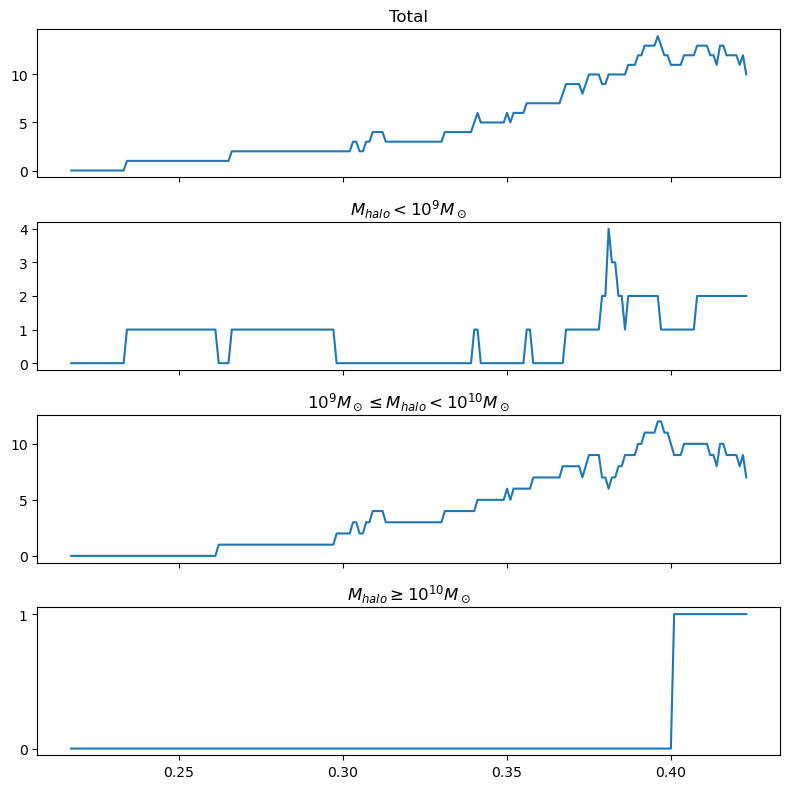

In [93]:
fig, axs = plt.subplots(ncols=1, nrows=4, sharex = True, figsize=(8,8))
axs[0].plot(time, n_halowstars_total)
axs[0].set_title('Total')

axs[1].plot(time, n_halowstars_range1)
axs[1].set_title(r'$M_{halo} < 10^{9} M_\odot$')

axs[2].plot(time, n_halowstars_range2)
axs[2].set_title(r'$10^{9} M_\odot \leq M_{halo} < 10^{10} M_\odot$')

axs[3].plot(time, n_halowstars_range3)
axs[3].set_title(r'$M_{halo} \geq 10^{10} M_\odot$')
axs[3].set_yticks([0,1])

fig.tight_layout()

In [94]:
def halom_sm_sfr(idx):
    halom = []
    sm = []
    sfr =[]
    redshift = ray_tree['0'][idx]['redshift']
    for branch in output_check[idx].keys():
        if output_check[idx][branch]['total_mass'] > 0:
            sm.append(output_check[idx][branch]['total_mass'])
            halom.append(ray_rawtree[branch][int(idx)]['Halo_Mass'])
            sfr.append(output_check[idx][branch]['sfr'])
    return halom, sm, sfr, redshift

In [95]:
halom1, sm1, sfr1, redshift1 = halom_sm_sfr('108')
halom, sm, sfr, redshift = halom_sm_sfr('211')
halom0, sm0, sfr0, redshift0 = halom_sm_sfr('4')

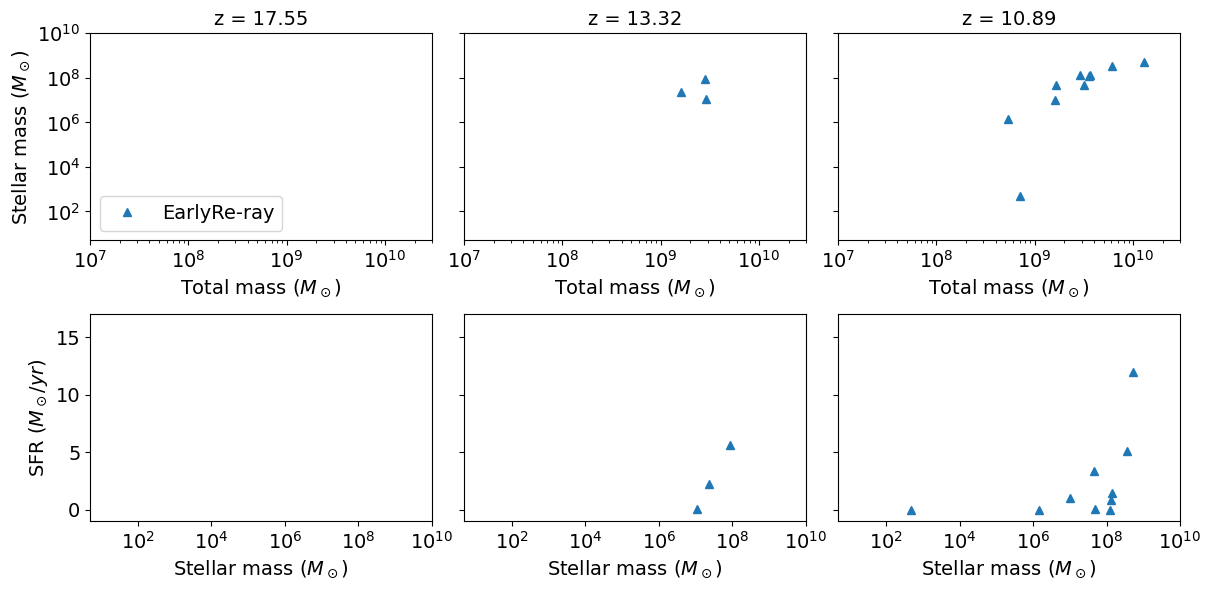

In [96]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, sharey = 'row', figsize=(12,6))

axs[0,0].plot(halom0, sm0,'^',label='EarlyRe-ray')
axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')
axs[0,0].set_xlabel(r'Total mass ($M_\odot$)', fontsize=14)
axs[0,0].set_ylabel(r'Stellar mass ($M_\odot$)', fontsize=14)
axs[0,0].set_ylim([0.5e1,1e10])
axs[0,0].set_xlim(1e7,3e10)
axs[0,0].set_title('z = %.2f' % redshift0, fontsize=14)
#plt.xticks([1e6,1e7,1e8,1e9,1e10])
axs[0,0].legend(loc='lower left', fontsize=14)
axs[0,0].tick_params(axis='both', which='major', labelsize=14)

axs[1,0].plot(sm0, sfr0,'^',label='EarlyRe-ray')
axs[1,0].set_xscale('log')
axs[1,0].set_xlabel(r'Stellar mass ($M_\odot$)', fontsize=14)
axs[1,0].set_ylabel(r'SFR ($M_\odot/yr$)', fontsize=14)
axs[1,0].set_xlim([0.5e1,1e10])
axs[1,0].set_ylim([-1,17])
axs[1,0].tick_params(axis='both', which='major', labelsize=14)

#------------------------------------------------------------------

axs[0,1].plot(halom1, sm1,'^',label='EarlyRe-ray')
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
axs[0,1].set_xlabel(r'Total mass ($M_\odot$)', fontsize=14)
axs[0,1].set_ylim([0.5e1,1e10])
axs[0,1].set_xlim(1e7,3e10)
axs[0,1].set_title('z = %.2f' % redshift1, fontsize=14)
axs[0,1].tick_params(axis='both', which='major', labelsize=14)

axs[1,1].plot(sm1, sfr1,'^',label='EarlyRe-ray')
axs[1,1].set_xscale('log')
axs[1,1].set_xlabel(r'Stellar mass ($M_\odot$)', fontsize=14)
axs[1,1].set_xlim([0.5e1,1e10])
axs[1,1].set_ylim([-1,17])
axs[1,1].tick_params(axis='both', which='major', labelsize=14)

#------------------------------------------------------------------

axs[0,2].plot(halom, sm,'^',label='EarlyRe-ray')
axs[0,2].set_xscale('log')
axs[0,2].set_yscale('log')
axs[0,2].set_xlabel(r'Total mass ($M_\odot$)', fontsize=14)
axs[0,2].set_ylim([0.5e1,1e10])
axs[0,2].set_xlim(1e7,3e10)
axs[0,2].set_title('z = %.2f' % redshift, fontsize=14)
axs[0,2].tick_params(axis='both', which='major', labelsize=14)

axs[1,2].plot(sm, sfr,'^',label='EarlyRe-ray')
axs[1,2].set_xscale('log')
axs[1,2].set_xlabel(r'Stellar mass ($M_\odot$)', fontsize=14)
axs[1,2].set_xlim([0.5e1,1e10])
axs[1,2].set_ylim([-1,17])
axs[1,2].tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()

#plt.savefig('/work/hdd/bbvl/tnguyen2/figures/self-shielding/SFR_stellarmass_totalmass_EarlyRe.png', dpi=300)

In [51]:
output_check['100']

{'1': {'ID': array([65333966, 65333967, 65333969, ..., 65440877, 65440878, 65440879]),
  'total_mass': 69602991.58186208,
  'sfr': 4.499585736544708},
 '7': {'ID': array([], dtype=int64), 'total_mass': 0.0, 'sfr': 0.0},
 '0_35': {'ID': array([65363536, 65363537, 65363538, 65363539, 65363540, 65363541,
         65363542, 65363543, 65363546, 65363549, 65363554, 65363555,
         65363558, 65363561, 65363565, 65363572, 65363576, 65363577,
         65363580, 65363587, 65363588, 65363590, 65363593, 65363596,
         65363599, 65363606, 65363607, 65363613, 65363616, 65363619,
         65363621, 65363624, 65363627, 65363636, 65363644, 65363646,
         65363648, 65363650, 65363651, 65363652, 65363653, 65363654,
         65363655, 65363656, 65363657, 65363658, 65363659, 65363660,
         65363661, 65363662, 65363663, 65363664, 65363665, 65363673,
         65363674, 65363683, 65363690, 65363698, 65363706, 65363714,
         65363722, 65363737, 65363738, 65363746, 65363753, 65363760,
       

In [10]:
output['101'].keys()

dict_keys(['1', '7', '0'])

In [10]:
ray_tree['1_22']['75']

{'tree_loc': '1_22',
 'coor': array([0.47356483, 0.50200012, 0.49968263]),
 'Rvir': 0.0017621845302556892,
 'redshift': 14.393940210744,
 'time': 0.2870843688082701,
 'gas_mass': 302999751.91776574,
 'gas_mass_frac': 0.1788584872392928,
 'h2_mass': 30722800.068975758,
 'h2_fraction': 0.1013954627834611,
 'dm_mass': 1370376768.8724527,
 'pop2_mass': 20698815.49721027,
 'pop3_mass': 0.0,
 'star_mass': 20698815.49721027,
 'metal_mass': 84355.03970861924,
 'metallicity': 0.0002783996989261999,
 'sfr': 0.0,
 'total_mass': 1694075336.2874289}

#### Testing each for loop step

In [61]:
idx = '196'
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_mass_all = ray_metadata['mass']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist()).astype(int)
ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])
ds = yt.load(ray_pfs[int(idx)])

if idx == '21':
    ray_ID_all_prev = np.array([])

yt : [INFO     ] 2025-01-02 05:34:59,572 Parameters: current_time              = 19.503658364245
yt : [INFO     ] 2025-01-02 05:34:59,574 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 05:34:59,576 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 05:34:59,578 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 05:34:59,580 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 05:34:59,582 Parameters: current_redshift          = 11.175654555311
yt : [INFO     ] 2025-01-02 05:34:59,583 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 05:34:59,585 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 05:34:59,587 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 05:34:59,588 Parameters: hubble_constant           = 0.679


In [62]:
ray_ID_unassign = np.setdiff1d(ray_ID_all, ray_ID_all_prev)
print(ray_ID_unassign)
ray_pos_unassign = ray_pos_all[np.intersect1d(ray_ID_all, ray_ID_unassign, return_indices=True)[1]]
ray_vel_unassign = ray_vel_all[np.intersect1d(ray_ID_all, ray_ID_unassign, return_indices=True)[1]]

[65769579 65769581 65769590 65769591 65769592 65769593 65769594 65769595
 65769596 65769597 65769598 65769599 65769603 65769604 65769607 65769608
 65769609 65769611 65769614 65769615 65769618 65769619 65769622 65769624
 65769625 65769626 65769627 65769628 65769629 65769631 65769632 65769635
 65769637 65769638 65769639 65769640 65769641 65769643 65769645 65769646
 65769647 65769649 65769650 65769651 65769652 65769653 65769655 65769656
 65769659 65769660 65769661 65769662 65769663 65769666 65769667 65769669
 65769671 65769672 65769673 65769674 65769675 65769676 65769678 65769680
 65769682 65769683 65769684]


In [63]:
halo_wstars_pos, halo_wstars_rvir, halo_wstars_branch = list_of_halos_wstars_idx(ray_tree, idx)
print(halo_wstars_branch)

['0' '0_14' '0_2' '0_8' '0_10' '0_6' '0_13' '1' '1_8' '3' '3_2' '3_1' '4'
 '4_2' '4_0' '5' '5_0' '6' '8' '8_3' '8_2' '9' '9_1' '9_1_1_0' '9_1_0'
 '20' '69' '69_1']


In [12]:
def find_total_E_multiple(star_pos, star_vel, ds, tree, branch, idx):
    #this function calculate the total orbital energy of a star around a halo
    #the unit of position is code_length and the unit of velocity is code_length/s
    if star_pos.shape == (3,):
        star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'])
    else:
        star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'], axis=1)
    star_r = (star_r_codelength*ds.units.code_length).to('m').v
    #
    halo_vel = (tree[branch][idx]['Vel_Com']*ds.units.code_length/ds.units.s).to('m/s').v
    if star_pos.shape == (3,):
        star_relvel_mag = np.linalg.norm(star_vel - halo_vel)
    else:
        star_relvel_mag = np.linalg.norm(star_vel - halo_vel, axis=1)
    #Kinetic energy
    KE = 0.5*star_relvel_mag**2
    #Approximate M(r < star_r) by using the overdensity
    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)
    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v
    oden_boolean = char_radius_list > star_r[:,np.newaxis]
    oden = np.array([])
    for j in range(len(oden_boolean)):
        oden = np.append(oden, oden_list[np.where(oden_boolean[j] == True)[0][-1]])
    #
    M = (4/3)*np.pi*oden*univDen(ds)*star_r**3
    PE = -G.value*M/star_r
    E = KE + PE
    return E

In [13]:
def find_total_E(star_pos, star_vel, ds, tree, branch, idx):
    #this function calculate the total orbital energy of a star around a halo
    #the unit of position is code_length and the unit of velocity is code_length/s
    star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'])
    star_r = (star_r_codelength*ds.units.code_length).to('m').v
    #
    halo_vel = (tree[branch][idx]['Vel_Com']*ds.units.code_length/ds.units.s).to('m/s').v
    star_relvel_mag = np.linalg.norm(star_vel - halo_vel)
    #Kinetic energy
    KE = 0.5*star_relvel_mag**2
    #Approximate M(r < star_r) by using the overdensity
    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)
    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v
    oden = oden_list[char_radius_list > star_r][-1]
    M = (4/3)*np.pi*oden*univDen(ds)*star_r**3
    PE = -G.value*M/star_r
    E = KE + PE
    return E

In [64]:
#The shape of halo_boolean is (X,Y), where X is the number of star particles and Y is the number of halos with stars
halo_boolean = np.linalg.norm(ray_pos_unassign[:, np.newaxis, :] - halo_wstars_pos, axis=2) <= halo_wstars_rvir
#The number of halos a star particle is in. For example, if this value = 2, the star particle is in the region of 2 halos
overlap_boolean = np.sum(halo_boolean, axis=1) 
#The list of stars in each halo's region
starmap_ID = []
    
ray_ID_overlap = ray_ID_unassign[overlap_boolean > 1]
halo_boolean_overlap = halo_boolean[overlap_boolean > 1]
ray_ID_indp = ray_ID_unassign[overlap_boolean == 1]
halo_boolean_indp = halo_boolean[overlap_boolean == 1]

for j in range(halo_boolean_indp.shape[1]):
    starmap_ID.append(ray_ID_indp[halo_boolean_indp[:,j]])
    
if len(ray_ID_overlap) > 0:
    print('OVERLAP DETECTED')
    ray_pos_overlap = ray_pos_unassign[overlap_boolean > 1]
    ray_vel_overlap = ray_vel_unassign[overlap_boolean > 1]
    #WRITE MORE CODE HERE TO IMPLEMENT THE DETERMINATION OF STARS TO SPECIFIC HALOS
    for k in range(len(ray_ID_overlap)):
        overlap_branch = halo_wstars_branch[halo_boolean_overlap[k]]
        E_list = np.array([])
        for branch in overlap_branch:
            E = find_total_E(ray_pos_overlap[k], ray_vel_overlap[k], ds, ray_rawtree, branch, int(idx))
            E_list = np.append(E_list, E)
        bound_branch = overlap_branch[np.argmin(E_list)]
        print('Star ID', ray_ID_overlap[k], 'belong to Branch', bound_branch, 'with energies', E_list)
        starmap_ID[list(halo_wstars_branch).index(bound_branch)] = np.append(starmap_ID[list(halo_wstars_branch).index(bound_branch)], ray_ID_overlap[k])

OVERLAP DETECTED
Star ID 65769579 belong to Branch 9_1_0 with energies [2.27404812e+09 2.31908535e+09 2.04412294e+09 7.04623371e+08]
Star ID 65769581 belong to Branch 9_1_0 with energies [2.27488678e+09 2.31944627e+09 2.04462480e+09 7.14668490e+08]
Star ID 65769590 belong to Branch 1_8 with energies [ 8.63616905e+08 -1.52323347e+09]
Star ID 65769591 belong to Branch 1_8 with energies [ 8.61315863e+08 -1.51637336e+09]
Star ID 65769592 belong to Branch 1_8 with energies [ 8.61467133e+08 -1.51652629e+09]
Star ID 65769593 belong to Branch 1_8 with energies [ 8.61599742e+08 -1.51664657e+09]
Star ID 65769594 belong to Branch 1_8 with energies [ 8.61760352e+08 -1.51678897e+09]
Star ID 65769595 belong to Branch 1_8 with energies [ 8.55008091e+08 -1.50751866e+09]
Star ID 65769596 belong to Branch 1_8 with energies [ 8.61904304e+08 -1.51690079e+09]
Star ID 65769597 belong to Branch 1_8 with energies [ 8.55124601e+08 -1.50772976e+09]
Star ID 65769598 belong to Branch 1_8 with energies [ 8.6204122

In [ ]:
""" Old version before 01/01/2024
#The shape of halo_boolean is (X,Y), where X is the number of star particles and Y is the number of halos with stars
halo_boolean = np.linalg.norm(ray_pos_unassign[:, np.newaxis, :] - halo_wstars_pos, axis=2) <= halo_wstars_rvir
#The number of halos a star particle is in. For example, if this value = 2, the star particle is in the region of 2 halos
overlap_boolean = np.sum(halo_boolean, axis=1) 
#The list of stars in each halo's region
starmap_ID = []
if len(overlap_boolean) > 0 and (overlap_boolean > 1).any() == True:
    print('OVERLAP DETECTED')
    for n in range(len(halo_wstars_branch)):
        starmap_ID.append(np.empty(0))
    ray_pos_overlap = ray_pos_unassign[overlap_boolean > 1]
    ray_vel_overlap = ray_vel_unassign[overlap_boolean > 1]
    ray_ID_overlap = ray_ID_unassign[overlap_boolean > 1]
    #WRITE MORE CODE HERE TO IMPLEMENT THE DETERMINATION OF STARS TO SPECIFIC HALOS
    for k in range(len(halo_boolean)):
        overlap_branch = halo_wstars_branch[halo_boolean[k]]
        E_list = np.array([])
        for branch in overlap_branch:
            E = find_total_E(ray_pos_overlap[k], ray_vel_overlap[k], ds, ray_rawtree, branch, int(idx))
            E_list = np.append(E_list, E)
        bound_branch = overlap_branch[np.argmin(E_list)]
        print('Star ID', ray_ID_overlap[k], 'belong to Branch', bound_branch)
        starmap_ID[list(halo_wstars_branch).index(bound_branch)] = np.append(starmap_ID[list(halo_wstars_branch).index(bound_branch)], ray_ID_overlap[k])
else: #if none of the stars are in overlapped halos
    for j in range(halo_boolean.shape[1]):
        starmap_ID.append(ray_ID_unassign[halo_boolean[:,j]])
"""

In [65]:
i = 24
if len(starmap_ID[i]) > 0: 
    for j in ray_tree[halo_wstars_branch[i]].keys(): #assuming when a star forms inside a halo, it will not leave that halo 
        if int(j) >= int(idx):
            if halo_wstars_branch[i] not in output[j].keys():
                output[j][halo_wstars_branch[i]] = starmap_ID[i]
            else:
                output[j][halo_wstars_branch[i]] = np.append(output[j][halo_wstars_branch[i]], starmap_ID[i])
    if halo_wstars_branch[i].count('_') > 1:
        print('SUB-SUB-BRANCHES DETECTED AT SNAPSHOT', idx)
    nlevels = halo_wstars_branch[i].count('_')
    #for subbranch (or deeper sub-branch), the stars in that sub-branch will belong to the branch at lower level after the two halos merge
    loop_branch = halo_wstars_branch[i]
    for level in range(nlevels):
        deepest_lvl = loop_branch.split('_')[-1]
        mainbranch = loop_branch.split('_' + deepest_lvl)[0]
        merge_timestep = np.max(np.array(list(ray_tree[loop_branch].keys())).astype(int)) + 1
        last_timestep = np.max(np.array(list(ray_tree[mainbranch].keys())).astype(int))
        for j in range(merge_timestep, last_timestep + 1):
            if mainbranch not in output[str(j)].keys():
                output[str(j)][mainbranch] = starmap_ID[i]
            else:
                output[str(j)][mainbranch] = np.append(output[str(j)][mainbranch], starmap_ID[i])
        loop_branch = mainbranch

SUB-SUB-BRANCHES DETECTED AT SNAPSHOT 196


In [71]:
output['210']['9_1_0']

array([65769579, 65769581])

In [31]:
ray_tree['9'].keys()

dict_keys(['158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211'])

In [26]:
ray_tree[halo_wstars_branch[i]].keys()

dict_keys(['47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195',

To do:
+ In a case where one particle belongs to multiple halos, write code to assign that star to a specific halo -> done
+ If a star particle belongs to a sub-branch (for example, '0_20'), add it to the main branch when the halos merge (in the example, add it to branch '0') (done, however, the code doesn't account for sub-sub halos yet (or deeper sub-branches) -> done
+ In the final step, double check whether all stars are located in each halos of all snapshots. If they are not, remove them. -> done


In [342]:
len(output['57']['1'])

269

### Star Assignment Technique using Energy Definition

In [2]:
def univDen(ds):
    # Hubble constant
    H0 = ds.hubble_constant * 100 * u.km/u.s/u.Mpc
    H = H0**2 * (ds.omega_matter*(1 + ds.current_redshift)**3 + ds.omega_lambda)  # Technically H^2
    G = 6.67e-11 * u.m**3/u.s**2/u.kg
    # Density of the universe
    den = (3*H/(8*np.pi*G)).to("kg/m**3") / u.kg * u.m**3
    return den.value

In [3]:
def extract_char_radius(tree, branch, idx):
    oden_list = np.array([100, 150, 200, 250, 300, 500, 700])
    char_radius_list = np.array([])
    for oden in oden_list:
        key = 'r%s' % oden
        char_radius_list = np.append(char_radius_list, tree[branch][idx][key])
    return oden_list, char_radius_list

In [4]:
def find_total_E(star_r, star_relvel_mag, ds, tree, branch, idx):
    #this function calculate the total orbital energy of a star around a halo
    #the unit of position is km and the unit of velocity is km/s
    KE = 0.5*star_relvel_mag**2
    #Approximate M(r < star_r) by using the overdensity
    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)
    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v
    oden = oden_list[char_radius_list > star_r][-1]
    #
    M = (4/3)*np.pi*oden*univDen(ds)*star_r**3
    PE = -G.value*M/star_r
    E = KE + PE
    return E

In [5]:
ray_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final.npy', allow_pickle=True).tolist()
ray_pfs = np.loadtxt('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/pfs_allsnaps_1088.txt', dtype=str).tolist()

In [6]:
idx = 170
branch = '0'

In [7]:
ds = yt.load(ray_pfs[idx])

yt : [INFO     ] 2024-12-13 18:28:03,482 Parameters: current_time              = 18.261035164245
yt : [INFO     ] 2024-12-13 18:28:03,484 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-12-13 18:28:03,485 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-12-13 18:28:03,486 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-12-13 18:28:03,487 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-12-13 18:28:03,488 Parameters: current_redshift          = 11.722141902049
yt : [INFO     ] 2024-12-13 18:28:03,489 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2024-12-13 18:28:03,489 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2024-12-13 18:28:03,490 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-12-13 18:28:03,491 Parameters: hubble_constant           = 0.679


In [8]:
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist())
ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])

In [32]:
ray_halo_center = ray_rawtree[branch][idx]['Halo_Center']
ray_halo_rvir = ray_rawtree[branch][idx]['Halo_Radius']
ray_halo_vel = ray_rawtree[branch][idx]['Vel_Com']

In [33]:
halo_boolean = np.linalg.norm(ray_pos_all - ray_halo_center, axis=1) < ray_halo_rvir
halo_star_pos = ray_pos_all[halo_boolean]
halo_star_r = np.linalg.norm(halo_star_pos - ray_halo_center, axis=1)
halo_star_r = (halo_star_r*ds.units.code_length).to('m').v
halo_star_vel = ray_vel_all[halo_boolean]
halo_star_relvel_mag = np.linalg.norm(halo_star_vel - ray_halo_vel, axis=1)
halo_star_relvel_mag = (halo_star_relvel_mag*ds.units.km/ds.units.s).to('m/s').v
halo_star_age = ray_age_all[halo_boolean]
halo_star_ID = ray_ID_all[halo_boolean]

In [34]:
E_list = []
for j in range(len(halo_star_r)):
    E_list.append(find_total_E(halo_star_r[j], halo_star_relvel_mag[j], ds, ray_rawtree, branch, idx))
E_list = np.array(E_list)

Text(0.5, 0, 'Distance to Halo Center / Rvir')

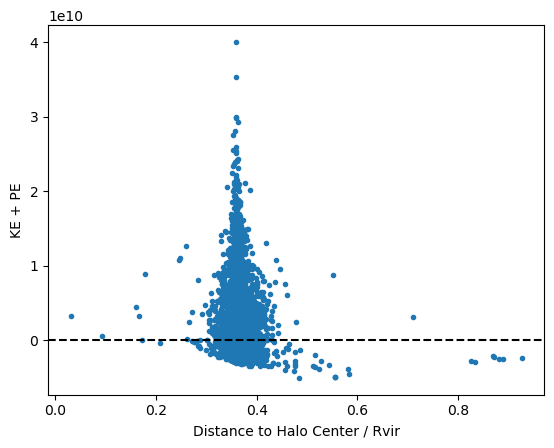

In [35]:
#sns.kdeplot(x = halo_star_r/(ray_halo_rvir*ds.units.code_length).to('m'), y = E_list, fill=True)
plt.plot(halo_star_r/(ray_halo_rvir*ds.units.code_length).to('m'), E_list, '.')
plt.axhline(0, linestyle='--', color='black')
plt.ylabel('KE + PE')
plt.xlabel('Distance to Halo Center / Rvir')

Only 30% of the stars are bound, which is unlikely. The error may come from the fact that the center of the stellar population is significantly off from the halo center, this introduces errors in the energy calculation. 

Suggestion from Kirk: subtract 

Use peak to determine the group of 

### Star Assignment Technique from AGORA Paper V and VII

Because SHINBAD output doesn't store the maximum circular velocity, we need to estimate it from the circular velocity at the virial radius

In [2]:
def weighted_std(values, weights_list):
    """
    Return the weighted standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights_list)
    N = len(values)
    # Fast and numerically precise:
    variance = np.sum(weights_list*(values-average)**2)/((N-1)*np.sum(weights_list)/N)
    return np.sqrt(variance)

In [3]:
def star_assignment(tree, branch, idx, pfs, sigma_cut = 2, distance_cut = 2):
    ds = yt.load(pfs[int(idx)])
    #
    branch = '0_4'
    halo_center = tree[branch][int(idx)]['Halo_Center']
    halo_rvir = tree[branch][int(idx)]['Halo_Radius']
    halo_mass = tree[branch][int(idx)]['Halo_Mass']
    halo_vel = tree[branch][int(idx)]['Vel_Com']
    halo_vel = (halo_vel*ds.units.code_length/ds.units.s).to('km/s').v
    #
    halo_rvir_si = ((halo_rvir*ds.units.code_length).to('m').v)*u.m
    halo_mass_si = ((halo_mass*ds.units.Msun).to('kg').v)*u.kg
    vcir = np.sqrt(G*halo_mass_si/halo_rvir_si).to('km/s').value #this is the circular velocity at r = Rvir
    #

In [17]:
idx = '194'
ray_pfs = np.loadtxt('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/pfs_allsnaps_1088.txt', dtype=str).tolist()
ds = yt.load(ray_pfs[int(idx)])

yt : [INFO     ] 2024-12-11 16:59:32,587 Parameters: current_time              = 19.408071964245
yt : [INFO     ] 2024-12-11 16:59:32,590 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-12-11 16:59:32,592 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-12-11 16:59:32,595 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-12-11 16:59:32,597 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-12-11 16:59:32,600 Parameters: current_redshift          = 11.215615860209
yt : [INFO     ] 2024-12-11 16:59:32,602 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2024-12-11 16:59:32,604 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2024-12-11 16:59:32,607 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-12-11 16:59:32,607 Parameters: hubble_constant           = 0.679


In [5]:
ray_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final.npy', allow_pickle=True).tolist()

In [18]:
branch = '0'
halo_center = ray_rawtree[branch][int(idx)]['Halo_Center']
halo_rvir = ray_rawtree[branch][int(idx)]['Halo_Radius']
halo_mass = ray_rawtree[branch][int(idx)]['Halo_Mass']
halo_vel = ray_rawtree[branch][int(idx)]['Vel_Com']
halo_vel = (halo_vel*ds.units.code_length/ds.units.s).to('km/s').v

halo_rvir_si = ((halo_rvir*ds.units.code_length).to('m').v)*u.m
halo_mass_si = ((halo_mass*ds.units.Msun).to('kg').v)*u.kg
vcir = np.sqrt(G*halo_mass_si/halo_rvir_si).to('km/s').value #this is the circular velocity at r = Rvir

In [19]:
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_mass_all = ray_metadata['mass']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist())
ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])

In [20]:
#Identify all the stars within the halo region
inreg_bool = np.linalg.norm(ray_pos_all - halo_center, axis=1) < halo_rvir
inreg_pos = ray_pos_all[inreg_bool]
inreg_r = np.linalg.norm(inreg_pos - halo_center, axis=1)
#
inreg_vel = ray_vel_all[inreg_bool]
inreg_relvel = inreg_vel - halo_vel
inreg_relvelmag = np.linalg.norm(inreg_relvel, axis=1)
#
inreg_ID = ray_ID_all[inreg_bool]
inreg_mass = ray_mass_all[inreg_bool]

In [21]:
sigma_cut = 2
distance_cut = 2

In [22]:
reduced_bool = np.logical_and(inreg_r < 0.8*halo_rvir, inreg_relvelmag < 4*vcir)
reduced_mass = inreg_mass[reduced_bool]
reduced_pos = inreg_pos[reduced_bool]
reduced_com = np.average(reduced_pos, weights=reduced_mass, axis=0)
#
reduced_vel = inreg_vel[reduced_bool]
reduced_relvel = reduced_vel - np.average(reduced_vel, weights=reduced_mass, axis=0)
reduced_relvelmag = np.linalg.norm(reduced_relvel, axis=1)
sigma_vel = weighted_std(reduced_relvelmag, weights_list=reduced_mass)
#
reduced_ID = inreg_ID[reduced_bool]

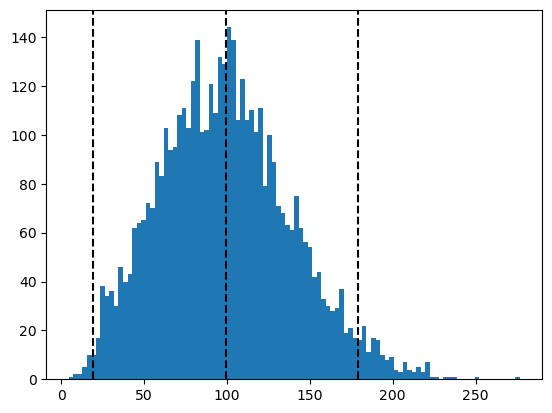

In [11]:
plt.hist(reduced_relvelmag, bins=100)
plt.axvline(np.average(reduced_relvelmag), color='k', linestyle='--')
plt.axvline(np.average(reduced_relvelmag) - sigma_cut*sigma_vel, color='k', linestyle='--')
plt.axvline(np.average(reduced_relvelmag) + sigma_cut*sigma_vel, color='k', linestyle='--')

In [23]:
def cal_R90(pos, center, mass):
    r = np.linalg.norm(pos - center, axis=1)
    r_sort = r[np.argsort(r)]
    mass_sort = mass[np.argsort(r)]
    mass_cumsum = np.cumsum(mass_sort)
    mass_cumsumpercent = mass_cumsum/mass_cumsum[-1]
    R90 = r_sort[np.where(mass_cumsumpercent > 0.9)[0][0]]
    return R90

In [24]:
r90_halocenter = cal_R90(reduced_pos, halo_center, reduced_mass)
r90_starcenter = cal_R90(reduced_pos, reduced_com, reduced_mass)

In [25]:
reduced2_bool = (np.linalg.norm(reduced_pos - halo_center, axis=1) < distance_cut*r90_halocenter) & \
                (np.linalg.norm(reduced_pos - reduced_com, axis=1) < distance_cut*r90_starcenter) & \
                (reduced_relvelmag <= np.average(reduced_relvelmag) + sigma_cut*sigma_vel)
reduced2_pos = reduced_pos[reduced2_bool]
reduced2_mass = reduced_mass[reduced2_bool]
reduced2_ID = reduced_ID[reduced2_bool]
reduced2_vel = reduced_vel[reduced2_bool]
reduced2_com = np.average(reduced2_pos, weights=reduced2_mass, axis=0)

In [26]:
counter = 0
while np.sum(reduced2_bool)/len(reduced2_bool) <= 0.99:
    if len(reduced2_pos) == 0:
        reduced2_com = np.nan
        break
    reduced2_relvel = reduced2_vel - np.average(reduced2_vel, weights=reduced2_mass, axis=0)
    reduced2_relvelmag = np.linalg.norm(reduced2_relvel, axis=1)
    #
    sigma_vel = weighted_std(reduced2_relvelmag, weights_list=reduced2_mass)
    r90_halocenter = cal_R90(reduced2_pos, halo_center, reduced2_mass)
    r90_starcenter = cal_R90(reduced2_pos, reduced2_com, reduced2_mass)
    #
    reduced2_bool = (np.linalg.norm(reduced2_pos - halo_center, axis=1) < distance_cut*r90_halocenter) & \
                    (np.linalg.norm(reduced2_pos - reduced2_com, axis=1) < distance_cut*r90_starcenter) & \
                    (reduced2_relvelmag <= np.average(reduced2_relvelmag) + sigma_cut*sigma_vel)
    reduced2_pos = reduced2_pos[reduced2_bool]
    reduced2_mass = reduced2_mass[reduced2_bool]
    reduced2_ID = reduced2_ID[reduced2_bool]
    reduced2_vel = reduced2_vel[reduced2_bool]
    reduced2_com = np.average(reduced2_pos, weights=reduced2_mass, axis=0)
    counter += 1
    print(counter)

1
2
3


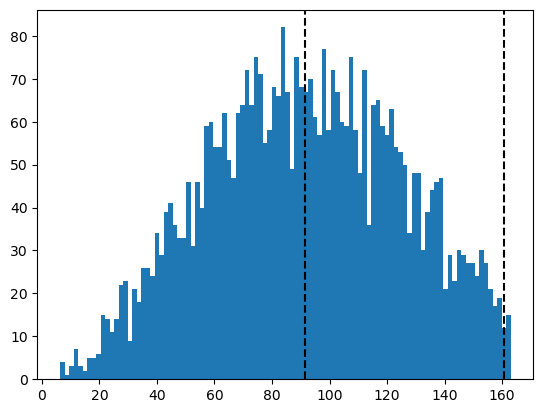

In [19]:
plt.hist(reduced2_relvelmag, bins=100)
plt.axvline(np.average(reduced2_relvelmag), color='k', linestyle='--')
plt.axvline(np.average(reduced2_relvelmag) + sigma_cut*sigma_vel, color='k', linestyle='--')

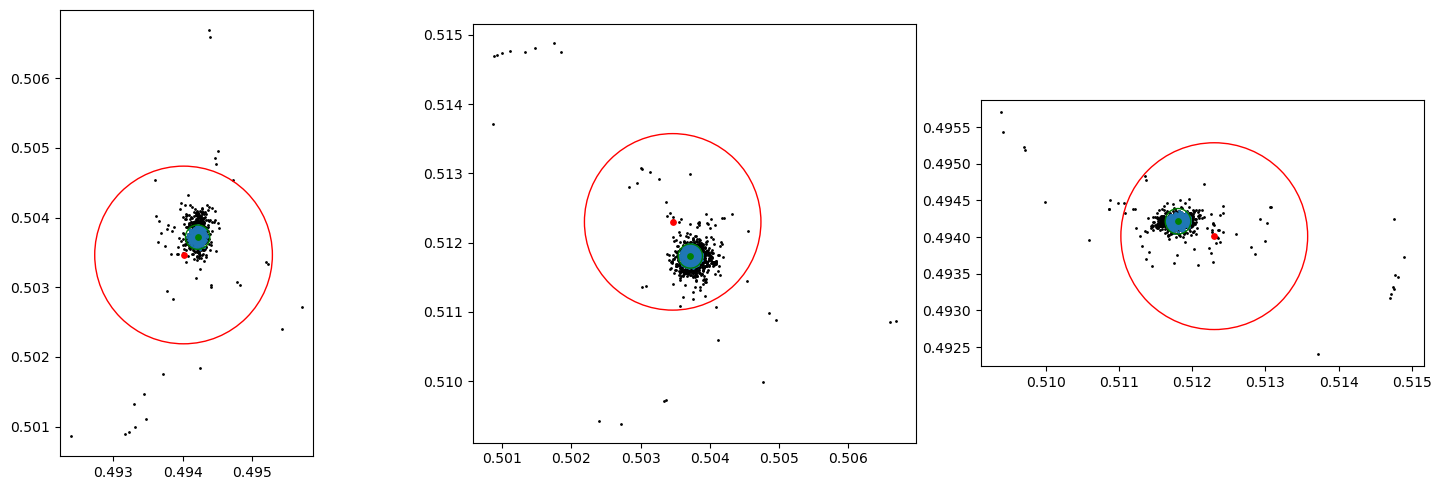

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

axs[0].scatter(inreg_pos[:,0], inreg_pos[:,1], s=1, color='black')

axs[0].scatter(reduced2_pos[:,0], reduced2_pos[:,1], s=1)

axs[0].scatter(halo_center[0], halo_center[1], color='red', s=15)
circle1 = plt.Circle((halo_center[0], halo_center[1]), distance_cut*r90_halocenter, color='red', fill=False)
axs[0].add_patch(circle1)

axs[0].scatter(reduced2_com[0], reduced2_com[1], color='green', s=15)
circle2 = plt.Circle((reduced2_com[0], reduced2_com[1]), distance_cut*r90_starcenter, color='green', fill=False)
axs[0].add_patch(circle2)

axs[0].set_aspect('equal')

#---------------------------------------------------------
axs[1].scatter(inreg_pos[:,1], inreg_pos[:,2], s=1, color='black')

axs[1].scatter(reduced2_pos[:,1], reduced2_pos[:,2], s=1)

axs[1].scatter(halo_center[1], halo_center[2], color='red', s=15)
circle1 = plt.Circle((halo_center[1], halo_center[2]), distance_cut*r90_halocenter, color='red', fill=False)
axs[1].add_patch(circle1)

axs[1].scatter(reduced2_com[1], reduced2_com[2], color='green', s=15)
circle2 = plt.Circle((reduced2_com[1], reduced2_com[2]), distance_cut*r90_starcenter, color='green', fill=False)
axs[1].add_patch(circle2)

axs[1].set_aspect('equal')
#---------------------------------------------------------
axs[2].scatter(inreg_pos[:,2], inreg_pos[:,0], s=1, color='black')

axs[2].scatter(reduced2_pos[:,2], reduced2_pos[:,0], s=1)

axs[2].scatter(halo_center[2], halo_center[0], color='red', s=15)
circle1 = plt.Circle((halo_center[2], halo_center[0]), distance_cut*r90_halocenter, color='red', fill=False)
axs[2].add_patch(circle1)

axs[2].scatter(reduced2_com[2], reduced2_com[0], color='green', s=15)
circle2 = plt.Circle((reduced2_com[2], reduced2_com[0]), distance_cut*r90_starcenter, color='green', fill=False)
axs[2].add_patch(circle2)

axs[2].set_aspect('equal')

fig.tight_layout()